## Dependency analysis

This notebook contains analysis of dependencies in Common Criteria certificates.


### Attention: All these analytics were computed on dataset from 2022-04-16

### Observations of the dependency analysis
- 3331 certificates are archived
- 1645 certificates are active 
- 3767 certificates referencing no other certificates: directly_affecting == Nan && indirectly_affecting == NaN
- 433 certificates are referenced by at least one archived certificate
- 16 out of total 936 BSI certificates reference at least one ANSSI certificate
- 214 out of total 725 ANSSI certificates reference at least one BSI certificate
- Certificates with specified EAL tend to reference certificates with same or higher EAL 
- Certificates with specified category are more likely to reference certificates in the same category
- Most common EAL in smart cards is EAL5+, lowest is EAL1+ and highest is EAL7
- BSI lab self-reference its certificates much more than products certified by other labs
- Germany scheme self-reference itself in comparison to referencing other scheme


#### Active certificates referencing at least one archived
Out of 1506 active certificates, 422 are referencing at least 1 certificate
Out of 422 referencing cert, 138 are referencing at least 1 already archived certificate


#### NSCIB + ANSSI + BSI
BSI: total of 936 records, 592 certificates reference at least one certificate
Out of 592 certificates 16 reference at least 1 ANSSI certificate
Out of 592 certificates 16 reference at least 1 NSCIB certificate

ANSSI: total of 725 records, 459 certificates reference at least one certificate
Out of 459 certificates 214 reference at least 1 BSI certificate
Out of 459 certificates 20 reference at least 1 NSCIB certificate

NSCIB: total of 182 records, 98 certificate reference at least one certificate
Out of 98 certificates 30 reference at least 1 BSI certificate
Out of 98 certificates 19 reference at least 1 ANSSI certificate


#### Cross References

- 26 pairs of certificates are crossed referenced

{'BSI-DSZ-CC-1033-V2-2021', 'BSI-DSZ-CC-1034-V2-2021'},  
{'BSI-DSZ-CC-1033-2019', 'BSI-DSZ-CC-1034-2019'},  
{'BSI-DSZ-CC-0996-2018', 'BSI-DSZ-CC-0995-2018'},   
{'BSI-DSZ-CC-0808-V3-2017', 'BSI-DSZ-CC-0809-V3-2017'},  
{'BSI-DSZ-CC-0913-2014', 'BSI-DSZ-CC-0911-2014'},  
{'BSI-DSZ-CC-0913-2014', 'BSI-DSZ-CC-0912-2014'},  
{'BSI-DSZ-CC-0913-2014', 'BSI-DSZ-CC-0914-2014'},   
{'BSI-DSZ-CC-0912-2014', 'BSI-DSZ-CC-0911-2014'},  
{'BSI-DSZ-CC-0914-2014', 'BSI-DSZ-CC-0911-2014'},  
{'BSI-DSZ-CC-0914-2014', 'BSI-DSZ-CC-0912-2014'},  
{'BSI-DSZ-CC-0895-2014', 'BSI-DSZ-CC-0894-2014'},  
{'BSI-DSZ-CC-1073-2019', 'BSI-DSZ-CC-1074-2019'},  
{'BSI-DSZ-CC-0808-V2-2016', 'BSI-DSZ-CC-0809-V2-2016'},  
{'BSI-DSZ-CC-0893-2014', 'BSI-DSZ-CC-0892-2014'},  
{'BSI-DSZ-CC-0851-2013', 'BSI-DSZ-CC-0850-2013'},  
{'BSI-DSZ-CC-0808-2013', 'BSI-DSZ-CC-0809-2013'},  
{'BSI-DSZ-CC-0885-2013', 'BSI-DSZ-CC-0886-2013'},  
{'BSI-DSZ-CC-0760-2013', 'BSI-DSZ-CC-0761-2013'},  
{'BSI-DSZ-CC-0762-2012', 'BSI-DSZ-CC-0763-2012'},  
{'BSI-DSZ-CC-0798-2012', 'BSI-DSZ-CC-0797-2012'},  
{'BSI-DSZ-CC-0798-2012', 'BSI-DSZ-CC-0799-2012'},  
{'BSI-DSZ-CC-0798-2012', 'BSI-DSZ-CC-0804-2012'},  
{'BSI-DSZ-CC-0797-2012', 'BSI-DSZ-CC-0799-2012'},  
{'BSI-DSZ-CC-0797-2012', 'BSI-DSZ-CC-0804-2012'},  
{'BSI-DSZ-CC-0804-2012', 'BSI-DSZ-CC-0799-2012'},  
{'BSI-DSZ-CC-0346-2006', 'BSI-DSZ-CC-0347-2006'}  

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections 
import datetime
import graphviz
import plotly.express as px
import plotly.graph_objects as go

from sec_certs.dataset.common_criteria import CCDataset
from typing import Tuple, List

plt.style.use("ggplot")

## Data Analysis Utilities

In [3]:
def plot_graphviz_graph(title, filename, nodes, data_dict):
    graph = graphviz.Digraph(comment=title)
    
    # Creation of nodes
    for node in nodes:
        graph.node(node, node)
        
    # Edges among nodes
    for node, references_dict in data_dict.items():
        for referenced_node in references_dict:
            if referenced_node is None:
                continue
            graph.edge(node, referenced_node, label=str(references_dict[referenced_node]))
    
    # Rendering graph to pdf file
    graph.render(format="pdf", filename=filename)
    
    print(f"{filename} has been rendered successfully")

In [4]:
def _sanitize_dict(references_dict):
    sanitized_dict = {}
    
    for node, references_dict in references_dict.items():
        sanitized_references_dict = {}
        
        for referenced_node in references_dict:
            if referenced_node is None:
                continue
            
            sanitized_references_dict[referenced_node] = references_dict[referenced_node]
        
        sanitized_dict[node] = sanitized_references_dict
    
    return sanitized_dict


def make_stacked_bar_plot(references_dict, title, xaxis_label, yaxis_label, category_orders=None):
    references_dict = _sanitize_dict(references_dict)  # removing None values
    
    references_df = pd.DataFrame(references_dict).transpose()
    fig = px.bar(references_df, title=title)
    fig.update_layout(xaxis_title=xaxis_label, yaxis_title=yaxis_label)
    
    if category_orders:
        fig = px.bar(references_df, title=title, category_orders={"variable": CC_EALS})
        fig.update_layout(legend_traceorder="reversed", xaxis_title=xaxis_label, yaxis_title=yaxis_label)

    fig.write_image(f"{title.lower()}.png")
    fig.show()

In [5]:
def make_heatmap_plot(references_dict, title, xaxis_label, yaxis_label, category_orders=None):
    references_dict = _sanitize_dict(references_dict)  # removing None values
    heatmap_dict = {}
    index = 0
    
    for source, source_dict in references_dict.items():

        for target in source_dict:
            count = source_dict[target]
            heatmap_dict[index] = {"source": source, "target": target, "count": count}
            index += 1

    heatmap_df = pd.DataFrame(heatmap_dict).transpose()

    fig = px.density_heatmap(heatmap_df, x="target", y="source", z="count", text_auto=True, color_continuous_scale='Blues', title=title)
    fig.update_xaxes(title=xaxis_label)
    
    if category_orders:
        fig.update_xaxes(title=xaxis_label, categoryorder='array', categoryarray= CC_EALS)
        
    fig.update_yaxes(title=yaxis_label)
    fig.write_image(f"{title.lower()}.png")
    fig.show()

In [7]:
dset = CCDataset.from_json("/home/george/disk_100/sbapr_dataset.json")
df = dset.to_pandas()

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

df.head()

Dataset has 4995 rows and 23 columns.


cert_id  \
dgst                                     
8298c7814b3b2860         KECS-CR-22-11   
9a1c767d358eee50  DXC-EFC-T092-ETR 1.0   
979e00ac7d3e229c         KECS-CR-21-63   
a6015339aa4434cf         KECS-CR-21-52   
a89ee15539d006d1           CSEC2019015   

                                                               name  status  \
dgst                                                                          
8298c7814b3b2860                                   KSignAccess V4.1  active   
9a1c767d358eee50    VeroGuard HSM Digital ID for Open Networks v1.0  active   
979e00ac7d3e229c                                  SafeIdentity v5.1  active   
a6015339aa4434cf                                     Bandi SSO v7.0  active   
a89ee15539d006d1  DriveLock Agent 2019.2 (Device and Application...  active   

                                            category  \
dgst                                                   
8298c7814b3b2860  Access Control Devices and Systems   
9a1c767d358eee50  Access Control Devices and Systems   
979e00ac7d3e229c  Access Control Devices and Systems   
a6015339aa4434cf  Access Control Devices and Systems   
a89ee15539d006d1  Access Control Devices and Systems   

                               manufacturer scheme cert_lab  \
dgst                                                          
8298c7814b3b2860            KSign Co., LTD.     KR      NaN   
9a1c767d358eee50  VeroGuard Systems Pty Ltd     AU      NaN   
979e00ac7d3e229c           Hancom With Inc.     KR      NaN   
a6015339aa4434cf                    Bandi S     KR      NaN   
a89ee15539d006d1               DriveLock SE     SE      NaN   

                      security_level not_valid_before not_valid_after  ...  \
dgst                                                                   ...   
8298c7814b3b2860                  {}       2022-03-30      2027-03-30  ...   
9a1c767d358eee50  {EAL2+, ALC_FLR.1}       2022-02-23      2027-02-23  ...   
979e00ac7d3e229c                  {}       2021-11-05      2026-11-05  ...   
a6015339aa4434cf                  {}       2021-09-08      2026-09-08  ...   
a89ee15539d006d1   {EAL3, ALC_FLR.3}       2021-04-07      2026-04-07  ...   

                 extracted_versions cpe_matches verified_cpe_matches  \
dgst                                                                   
8298c7814b3b2860              {4.1}         NaN                  NaN   
9a1c767d358eee50              {1.0}         NaN                  NaN   
979e00ac7d3e229c              {5.1}         NaN                  NaN   
a6015339aa4434cf              {7.0}         NaN                  NaN   
a89ee15539d006d1           {2019.2}         NaN                  NaN   

                 related_cves directly_referenced_by  \
dgst                                                   
8298c7814b3b2860          NaN                    NaN   
9a1c767d358eee50          NaN                    NaN   
979e00ac7d3e229c          NaN                    NaN   
a6015339aa4434cf          NaN                    NaN   
a89ee15539d006d1          NaN                    NaN   

                  indirectly_referenced_by directly_referencing  \
dgst                                                              
8298c7814b3b2860                       NaN                  NaN   
9a1c767d358eee50                       NaN                  NaN   
979e00ac7d3e229c                       NaN                  NaN   
a6015339aa4434cf                       NaN                  NaN   
a89ee15539d006d1                       NaN                  NaN   

                 indirectly_referencing direct_dependency_cves  \
dgst                                                             
8298c7814b3b2860                    NaN                    NaN   
9a1c767d358eee50                    NaN                    NaN   
979e00ac7d3e229c                    NaN                    NaN   
a6015339aa4434cf                    NaN                    NaN   
a89ee15539d006d1                    

In [8]:
sum(df["direct_dependency_cves"].notna())

35

In [9]:
import dataframe_image as dfi

# BSI: total of 944 records, 599 certificates reference at least one certificate
# Out of 599 certificates 16 reference at least 1 ANSSI certificate
# Out of 599 certificates 16 reference at least 1 NSCIB certificate
# Out of 599 certificates 588 reference at least 1 BSI certificate

# ANSSI: total of 725 records, 459 certificates reference at least one certificate
# Out of 459 certificates 214 reference at least 1 BSI certificate
# Out of 459 certificates 20 reference at least 1 NSCIB certificate
# Out of 459 certificates 334 reference at least 1 ANSSI certificate

# NSCIB: total of 185 records, 98 certificate reference at least one certificate
# Out of 98 certificates 30 reference at least 1 BSI certificate
# Out of 98 certificates 19 reference at least 1 ANSSI certificate
# Out of 98 certificates 67 reference at least 1 NSCIB certificate
data = {
    "Total records": [944, 725, 185],
    "Total referencing records": [599, 459, 98],
    "Referencing BSI": [588, 214, 30],
    "Referencing ANSSI": [16, 334, 19],
    "Referencing NSCIB": [16, 20, 67],
}
special_df = pd.DataFrame(data, index = ["BSI", "ANSSI", "NSCIB"])

dfi.export(special_df, 'bsi_anssi_nscib_table.png')
print("Done")
special_df.head()

[0513/063718.296945:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0513/063718.316434:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0513/063718.472831:INFO:headless_shell.cc(659)] Written to file /tmp/tmphuye1xb7/temp.png.


Done


Total records  Total referencing records  Referencing BSI  \
BSI              944                        599              588   
ANSSI            725                        459              214   
NSCIB            185                         98               30   

       Referencing ANSSI  Referencing NSCIB  
BSI                   16                 16  
ANSSI                334                 20  
NSCIB                 19                 67

In [10]:
df.head()

cert_id  \
dgst                                     
8298c7814b3b2860         KECS-CR-22-11   
9a1c767d358eee50  DXC-EFC-T092-ETR 1.0   
979e00ac7d3e229c         KECS-CR-21-63   
a6015339aa4434cf         KECS-CR-21-52   
a89ee15539d006d1           CSEC2019015   

                                                               name  status  \
dgst                                                                          
8298c7814b3b2860                                   KSignAccess V4.1  active   
9a1c767d358eee50    VeroGuard HSM Digital ID for Open Networks v1.0  active   
979e00ac7d3e229c                                  SafeIdentity v5.1  active   
a6015339aa4434cf                                     Bandi SSO v7.0  active   
a89ee15539d006d1  DriveLock Agent 2019.2 (Device and Application...  active   

                                            category  \
dgst                                                   
8298c7814b3b2860  Access Control Devices and Systems   
9a1c767d358eee50  Access Control Devices and Systems   
979e00ac7d3e229c  Access Control Devices and Systems   
a6015339aa4434cf  Access Control Devices and Systems   
a89ee15539d006d1  Access Control Devices and Systems   

                               manufacturer scheme cert_lab  \
dgst                                                          
8298c7814b3b2860            KSign Co., LTD.     KR      NaN   
9a1c767d358eee50  VeroGuard Systems Pty Ltd     AU      NaN   
979e00ac7d3e229c           Hancom With Inc.     KR      NaN   
a6015339aa4434cf                    Bandi S     KR      NaN   
a89ee15539d006d1               DriveLock SE     SE      NaN   

                      security_level not_valid_before not_valid_after  ...  \
dgst                                                                   ...   
8298c7814b3b2860                  {}       2022-03-30      2027-03-30  ...   
9a1c767d358eee50  {EAL2+, ALC_FLR.1}       2022-02-23      2027-02-23  ...   
979e00ac7d3e229c                  {}       2021-11-05      2026-11-05  ...   
a6015339aa4434cf                  {}       2021-09-08      2026-09-08  ...   
a89ee15539d006d1   {EAL3, ALC_FLR.3}       2021-04-07      2026-04-07  ...   

                 extracted_versions cpe_matches verified_cpe_matches  \
dgst                                                                   
8298c7814b3b2860              {4.1}         NaN                  NaN   
9a1c767d358eee50              {1.0}         NaN                  NaN   
979e00ac7d3e229c              {5.1}         NaN                  NaN   
a6015339aa4434cf              {7.0}         NaN                  NaN   
a89ee15539d006d1           {2019.2}         NaN                  NaN   

                 related_cves directly_referenced_by  \
dgst                                                   
8298c7814b3b2860          NaN                    NaN   
9a1c767d358eee50          NaN                    NaN   
979e00ac7d3e229c          NaN                    NaN   
a6015339aa4434cf          NaN                    NaN   
a89ee15539d006d1          NaN                    NaN   

                  indirectly_referenced_by directly_referencing  \
dgst                                                              
8298c7814b3b2860                       NaN                  NaN   
9a1c767d358eee50                       NaN                  NaN   
979e00ac7d3e229c                       NaN                  NaN   
a6015339aa4434cf                       NaN                  NaN   
a89ee15539d006d1                       NaN                  NaN   

                 indirectly_referencing direct_dependency_cves  \
dgst                                                             
8298c7814b3b2860                    NaN                    NaN   
9a1c767d358eee50                    NaN                    NaN   
979e00ac7d3e229c                    NaN                    NaN   
a6015339aa4434cf                    NaN                    NaN   
a89ee15539d006d1                    

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4995 entries, 8298c7814b3b2860 to 09b17cb9b3c8b1bb
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   cert_id                   4643 non-null   object        
 1   name                      4995 non-null   object        
 2   status                    4995 non-null   category      
 3   category                  4995 non-null   category      
 4   manufacturer              4995 non-null   object        
 5   scheme                    4995 non-null   category      
 6   cert_lab                  3124 non-null   object        
 7   security_level            4995 non-null   object        
 8   not_valid_before          4995 non-null   datetime64[ns]
 9   not_valid_after           4746 non-null   datetime64[ns]
 10  report_link               4995 non-null   object        
 11  st_link                   4995 non-null   object        
 12

#### References

In [12]:
def calculate_reference_mean(reference_type):
    total_referencing_records = sum(df[reference_type].notna())
    print(f"Total records for {reference_type}: {total_referencing_records}")
    
    count = 0

    for reference_set in df[reference_type]:
        if reference_set is np.nan:
            continue

        count += len(reference_set)

    print(f"Total counts for {reference_type}: {count}")    
    print(f"{reference_type}: mean {round(count / total_referencing_records, 2)}")
    print()
    


for reference_type in [
    "directly_referencing",
    "indirectly_referencing",
    "directly_referenced_by", 
    "indirectly_referenced_by",]:
    calculate_reference_mean(reference_type)

Total records for directly_referencing: 1213
Total counts for directly_referencing: 2165
directly_referencing: mean 1.78

Total records for indirectly_referencing: 1213
Total counts for indirectly_referencing: 4608
indirectly_referencing: mean 3.8

Total records for directly_referenced_by: 665
Total counts for directly_referenced_by: 1670
directly_referenced_by: mean 2.51

Total records for indirectly_referenced_by: 665
Total counts for indirectly_referenced_by: 3767
indirectly_referenced_by: mean 5.66



### Filter top 10 manufacturers and see which categories are the most common

In [13]:
MANUFACTURER_COUNT = 10
top_manufacturers_list = df[df["manufacturer"].notna()]["manufacturer"].value_counts().head(MANUFACTURER_COUNT).index.tolist()
top_manufacturers_df = df[df["manufacturer"].isin(top_manufacturers_list)]
top_manufacturers_df["category"].value_counts()

ICs, Smart Cards and Smart Card-Related Devices and Systems    495
Multi-Function Devices                                         176
Other Devices and Systems                                      110
Network and Network-Related Devices and Systems                104
Operating Systems                                               78
Trusted Computing                                               45
Databases                                                       31
Data Protection                                                 25
Mobility                                                        25
Boundary Protection Devices and Systems                         19
Access Control Devices and Systems                              13
Detection Devices and Systems                                    5
Key Management Systems                                           4
Products for Digital Signatures                                  3
Biometric Systems and Devices                                 

### How many archived certificates are in dataset?

In [14]:
archived_df = df[df["status"] == "archived"]
print(f"There are total {archived_df.shape[0]} archived certificates.")

There are total 3342 archived certificates.


### How many active certificates are in dataset?

In [15]:
active_df = df[df["status"] == "active"]
print(f"There are total {active_df.shape[0]} active certificates.")

There are total 1653 active certificates.


In [16]:
df["category"].value_counts()

ICs, Smart Cards and Smart Card-Related Devices and Systems    1604
Other Devices and Systems                                       854
Network and Network-Related Devices and Systems                 689
Multi-Function Devices                                          534
Boundary Protection Devices and Systems                         233
Operating Systems                                               213
Data Protection                                                 210
Products for Digital Signatures                                 145
Access Control Devices and Systems                              144
Databases                                                        91
Mobility                                                         82
Detection Devices and Systems                                    75
Trusted Computing                                                60
Key Management Systems                                           58
Biometric Systems and Devices                   

In [17]:
1604 / df.shape[0]

0.3211211211211211

#### European Schemes and subset of Germany, France, Netherland

In [18]:
df.shape[0]

4995

In [19]:
EUROPEAN_SCHEMES = ["SE", 'NL', 'ES', 'DE', 'IT', 'NO', 'FR', 'UK', 'TR']
SUB_SCHEMES = ["DE", "FR", "NL"]

df[df["scheme"].isin(SUB_SCHEMES)].shape[0]

2039

Done


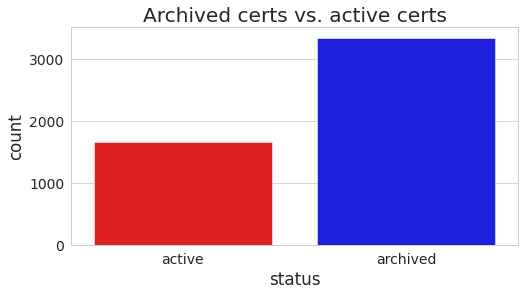

In [20]:
plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

sns.countplot(x=df["status"], palette=['r', 'b']).set_title("Archived certs vs. active certs")

plt.savefig("archived_active.png")
print("Done")

In [21]:
# Archived vs. active in each category
fig = px.density_heatmap(df, x="category", y="status")
fig.show()

### Which certificates are referenced at least by one certificate? 

In [22]:
def is_directly_affected_by(references):
    if references is np.nan:
        return False
    
    return True

def count_directly_affected_by(references):
    if references is np.nan:
        return np.nan
    return len(references)

directly_affected_by_df = df.copy()
directly_affected_by_df["is_directly_referenced_by"] = df["directly_referenced_by"].apply(is_directly_affected_by)
directly_affected_by_df["directly_referenced_by_sum"] = directly_affected_by_df["directly_referenced_by"].apply(count_directly_affected_by)
directly_affected_by_df.sort_values(by="directly_referenced_by_sum", ascending=False, inplace=True)
directly_affected_by_df.head()

cert_id  \
dgst                                        
f041e5b526e79ef4     BSI-DSZ-CC-0410-2007   
dfc0e5c6e48f7c5a  BSI-DSZ-CC-0837-V2-2014   
9dab3f1341f54c42     BSI-DSZ-CC-0555-2009   
dd000f356b48904d     BSI-DSZ-CC-0813-2012   
e2e705cabd42e40e     BSI-DSZ-CC-0829-2012   

                                                               name    status  \
dgst                                                                            
f041e5b526e79ef4  NXP Secure Smart Card Controller P5CD080V0B, P...  archived   
dfc0e5c6e48f7c5a  NXP Secure Smart Card Controller P60x080/052/0...    active   
9dab3f1341f54c42  NXP Smart Card Controller P5CD081V1A and its m...  archived   
dd000f356b48904d  Infineon smart card IC (Security Controller) M...  archived   
e2e705cabd42e40e  Infineon smart card IC (Security Controller) M...  archived   

                                                           category  \
dgst                                                                  
f041e5b526e79ef4  ICs, Smart Cards and Smart Card-Related Device...   
dfc0e5c6e48f7c5a  ICs, Smart Cards and Smart Card-Related Device...   
9dab3f1341f54c42  ICs, Smart Cards and Smart Card-Related Device...   
dd000f356b48904d  ICs, Smart Cards and Smart Card-Related Device...   
e2e705cabd42e40e  ICs, Smart Cards and Smart Card-Related Device...   

                                                       manufacturer scheme  \
dgst                                                                         
f041e5b526e79ef4  NXP Semiconductors Germany GmbH Business Line ...     DE   
dfc0e5c6e48f7c5a  NXP Semiconductors Germany GmbH Business Line ...     DE   
9dab3f1341f54c42                                 NXP Semiconductors     DE   
dd000f356b48904d                           Infineon Technologies AG     DE   
e2e705cabd42e40e                           Infineon Technologies AG     DE   

                 cert_lab                            security_level  \
dgst                                                                  
f041e5b526e79ef4    [BSI]  {AVA_MSU.3, ALC_DVS.2, AVA_VLA.4, EAL5+}   
dfc0e5c6e48f7c5a    [BSI]             {ALC_FLR.1, ASE_TSS.2, EAL6+}   
9dab3f1341f54c42    [BSI]                                   {EAL5+}   
dd000f356b48904d    [BSI]             {ALC_DVS.2, EAL5+, AVA_VAN.5}   
e2e705cabd42e40e    [BSI]             {ALC_DVS.2, EAL5+, AVA_VAN.5}   

                 not_valid_before not_valid_after  ... verified_cpe_matches  \
dgst                                               ...                        
f041e5b526e79ef4       2007-07-05      2019-09-01  ...                  NaN   
dfc0e5c6e48f7c5a       2014-10-24             NaT  ...                  NaN   
9dab3f1341f54c42       2009-11-10      2019-09-01  ...                  NaN   
dd000f356b48904d       2012-06-06      2019-09-01  ...                  NaN   
e2e705cabd42e40e       2012-09-05      2019-09-01  ...                  NaN   

                 related_cves  \
dgst                            
f041e5b526e79ef4          NaN   
dfc0e5c6e48f7c5a          NaN   
9dab3f1341f54c42          NaN   
dd000f356b48904d          NaN   
e2e705cabd42e40e          NaN   

                                             directly_referenced_by  \
dgst                                                                  
f041e5b526e79ef4  {ANSSI-2009/19, ANSSI-CC-2009/36, BSI-DSZ-CC-0...   
dfc0e5c6e48f7c5a  {ANSSI-CC-2015/08, ANSSI-CC-2016/46, ANSSI-CC-...   
9dab3f1341f54c42  {ANSSI-CC-2012/76, ANSSI-CC-2012/80, BSI-DSZ-C...   
dd000f356b48904d  {BSI-DSZ-CC-0941-2016, ANSSI-CC-2012/50, BSI-D...   
e2e705cabd42e40e  {ANSSI-CC-2013/64, ANSSI-CC-2013/32, ANSSI-CC-...   

                                           indirectly_referenced_by  \
dgst                                                                  
f041e5b526e79ef4  {ANSSI-2009/19, ANSSI-CC-2009/36, BSI-DSZ-CC-0...   
dfc0e5c6e48f7c5a  {ANSSI-CC-2015/08, ANSSI-CC-2016/46, ANSSI-CC-...   
9dab3f1341f54c42  {ANSSI-CC-2012/76, AN

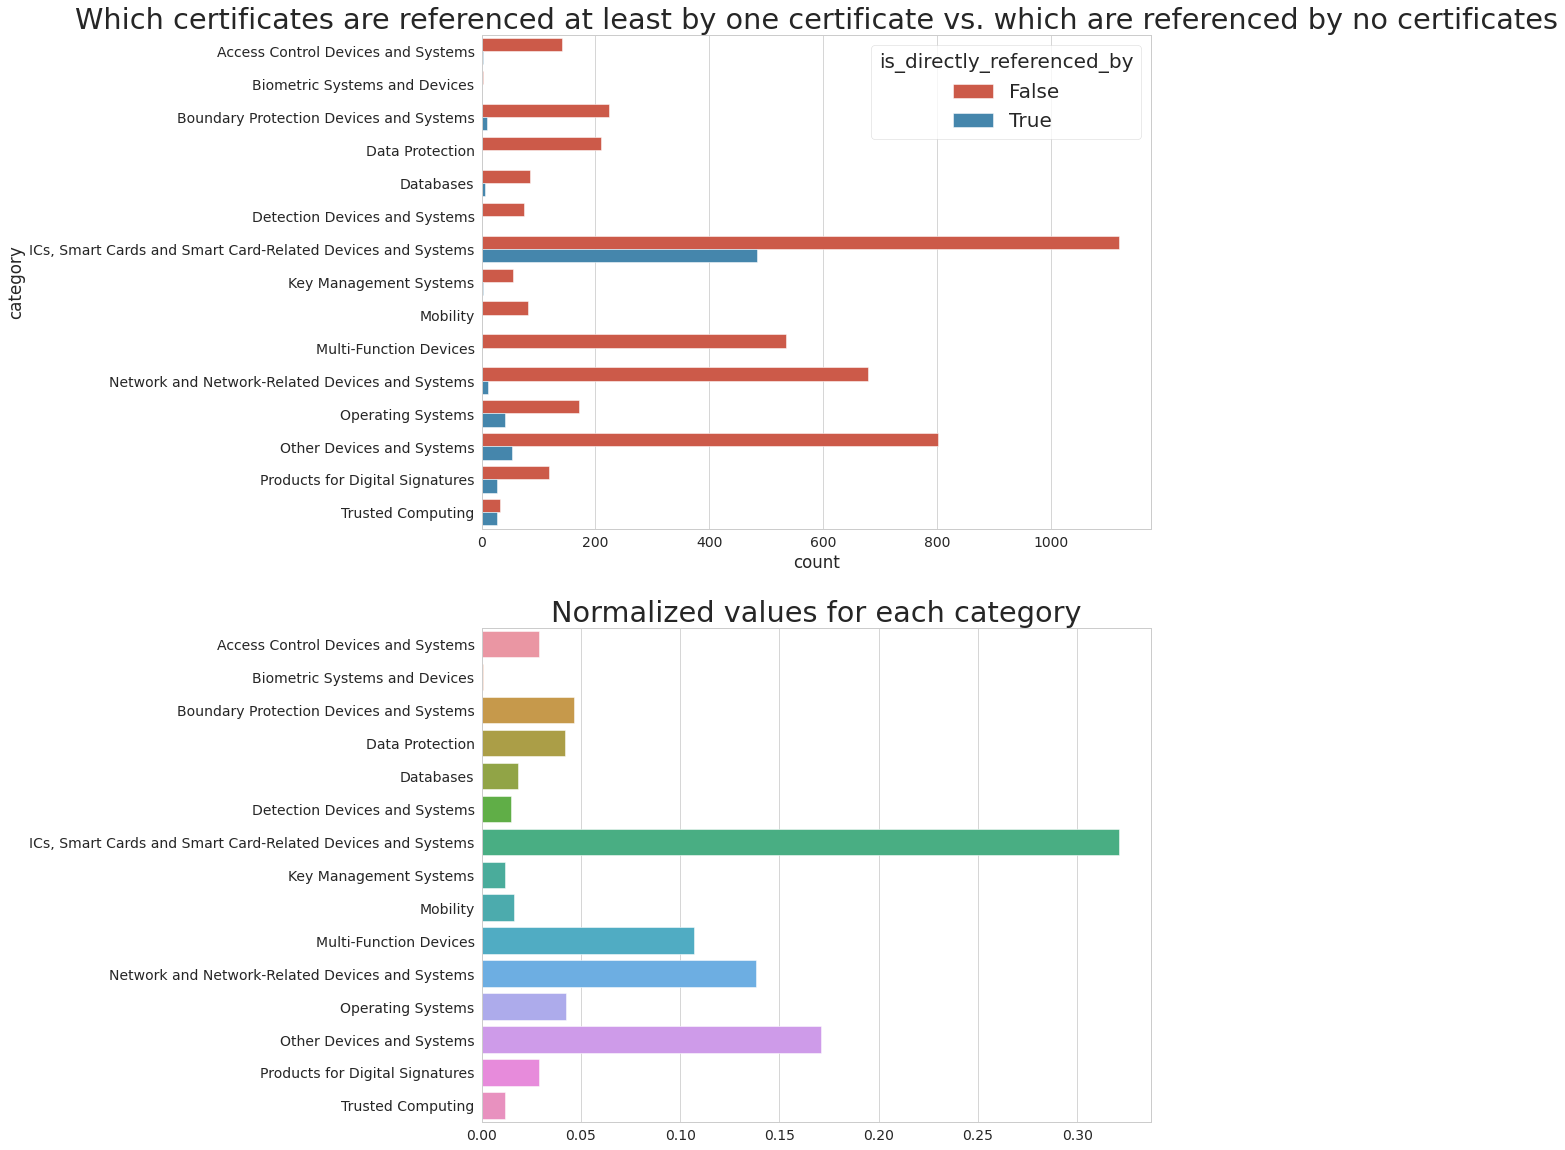

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = directly_affected_by_df["category"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="category", hue="is_directly_referenced_by", data=directly_affected_by_df, ax=ax1).set_title("Which certificates are referenced at least by one certificate vs. which are referenced by no certificates")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each category")
plt.show()

### Which certificates are referencing no other?

In [24]:
no_affecting_df = df[df["directly_referencing"].isna() & df["indirectly_referencing"].isna()]

print(f"There are total {no_affecting_df.shape[0]} certificates referencing no other certificates.")

There are total 3782 certificates referencing no other certificates.


In [25]:
no_affecting_df.head()

cert_id  \
dgst                                     
8298c7814b3b2860         KECS-CR-22-11   
9a1c767d358eee50  DXC-EFC-T092-ETR 1.0   
979e00ac7d3e229c         KECS-CR-21-63   
a6015339aa4434cf         KECS-CR-21-52   
a89ee15539d006d1           CSEC2019015   

                                                               name  status  \
dgst                                                                          
8298c7814b3b2860                                   KSignAccess V4.1  active   
9a1c767d358eee50    VeroGuard HSM Digital ID for Open Networks v1.0  active   
979e00ac7d3e229c                                  SafeIdentity v5.1  active   
a6015339aa4434cf                                     Bandi SSO v7.0  active   
a89ee15539d006d1  DriveLock Agent 2019.2 (Device and Application...  active   

                                            category  \
dgst                                                   
8298c7814b3b2860  Access Control Devices and Systems   
9a1c767d358eee50  Access Control Devices and Systems   
979e00ac7d3e229c  Access Control Devices and Systems   
a6015339aa4434cf  Access Control Devices and Systems   
a89ee15539d006d1  Access Control Devices and Systems   

                               manufacturer scheme cert_lab  \
dgst                                                          
8298c7814b3b2860            KSign Co., LTD.     KR      NaN   
9a1c767d358eee50  VeroGuard Systems Pty Ltd     AU      NaN   
979e00ac7d3e229c           Hancom With Inc.     KR      NaN   
a6015339aa4434cf                    Bandi S     KR      NaN   
a89ee15539d006d1               DriveLock SE     SE      NaN   

                      security_level not_valid_before not_valid_after  ...  \
dgst                                                                   ...   
8298c7814b3b2860                  {}       2022-03-30      2027-03-30  ...   
9a1c767d358eee50  {EAL2+, ALC_FLR.1}       2022-02-23      2027-02-23  ...   
979e00ac7d3e229c                  {}       2021-11-05      2026-11-05  ...   
a6015339aa4434cf                  {}       2021-09-08      2026-09-08  ...   
a89ee15539d006d1   {EAL3, ALC_FLR.3}       2021-04-07      2026-04-07  ...   

                 extracted_versions cpe_matches verified_cpe_matches  \
dgst                                                                   
8298c7814b3b2860              {4.1}         NaN                  NaN   
9a1c767d358eee50              {1.0}         NaN                  NaN   
979e00ac7d3e229c              {5.1}         NaN                  NaN   
a6015339aa4434cf              {7.0}         NaN                  NaN   
a89ee15539d006d1           {2019.2}         NaN                  NaN   

                 related_cves directly_referenced_by  \
dgst                                                   
8298c7814b3b2860          NaN                    NaN   
9a1c767d358eee50          NaN                    NaN   
979e00ac7d3e229c          NaN                    NaN   
a6015339aa4434cf          NaN                    NaN   
a89ee15539d006d1          NaN                    NaN   

                  indirectly_referenced_by directly_referencing  \
dgst                                                              
8298c7814b3b2860                       NaN                  NaN   
9a1c767d358eee50                       NaN                  NaN   
979e00ac7d3e229c                       NaN                  NaN   
a6015339aa4434cf                       NaN                  NaN   
a89ee15539d006d1                       NaN                  NaN   

                 indirectly_referencing direct_dependency_cves  \
dgst                                                             
8298c7814b3b2860                    NaN                    NaN   
9a1c767d358eee50                    NaN                    NaN   
979e00ac7d3e229c                    NaN                    NaN   
a6015339aa4434cf                    NaN                    NaN   
a89ee15539d006d1                    

### How many no affecting certificates are affected by other certificates?

In [26]:
affected_but_no_affecting_df = no_affecting_df[no_affecting_df["directly_referenced_by"].notna() & no_affecting_df["indirectly_referenced_by"].notna()]
print(f"There are total of {affected_but_no_affecting_df.shape[0]} certificates which are affected by other certificates and affecting no certificates.")

There are total of 195 certificates which are affected by other certificates and affecting no certificates.


### How many certificates are not affected by other certificates, nor affecting other certificates?

In [27]:
def is_no_affecting_nor_affected(directly_affecting, indirectly_affecting, directly_affected_by, indirectly_affected_by):
    if directly_affecting is np.nan and indirectly_affecting is np.nan and directly_affected_by is np.nan and indirectly_affected_by is np.nan:
        return True
    
    return False


no_affecting_no_affected_df = df.copy()
no_affecting_no_affected_df["is_no_referencing_nor_referenced"] = df.apply(lambda x: is_no_affecting_nor_affected(x["directly_referencing"], x["indirectly_referencing"], x["directly_referenced_by"], x["indirectly_referenced_by"]), axis=1)
no_affecting_no_affected_df.head()

cert_id  \
dgst                                     
8298c7814b3b2860         KECS-CR-22-11   
9a1c767d358eee50  DXC-EFC-T092-ETR 1.0   
979e00ac7d3e229c         KECS-CR-21-63   
a6015339aa4434cf         KECS-CR-21-52   
a89ee15539d006d1           CSEC2019015   

                                                               name  status  \
dgst                                                                          
8298c7814b3b2860                                   KSignAccess V4.1  active   
9a1c767d358eee50    VeroGuard HSM Digital ID for Open Networks v1.0  active   
979e00ac7d3e229c                                  SafeIdentity v5.1  active   
a6015339aa4434cf                                     Bandi SSO v7.0  active   
a89ee15539d006d1  DriveLock Agent 2019.2 (Device and Application...  active   

                                            category  \
dgst                                                   
8298c7814b3b2860  Access Control Devices and Systems   
9a1c767d358eee50  Access Control Devices and Systems   
979e00ac7d3e229c  Access Control Devices and Systems   
a6015339aa4434cf  Access Control Devices and Systems   
a89ee15539d006d1  Access Control Devices and Systems   

                               manufacturer scheme cert_lab  \
dgst                                                          
8298c7814b3b2860            KSign Co., LTD.     KR      NaN   
9a1c767d358eee50  VeroGuard Systems Pty Ltd     AU      NaN   
979e00ac7d3e229c           Hancom With Inc.     KR      NaN   
a6015339aa4434cf                    Bandi S     KR      NaN   
a89ee15539d006d1               DriveLock SE     SE      NaN   

                      security_level not_valid_before not_valid_after  ...  \
dgst                                                                   ...   
8298c7814b3b2860                  {}       2022-03-30      2027-03-30  ...   
9a1c767d358eee50  {EAL2+, ALC_FLR.1}       2022-02-23      2027-02-23  ...   
979e00ac7d3e229c                  {}       2021-11-05      2026-11-05  ...   
a6015339aa4434cf                  {}       2021-09-08      2026-09-08  ...   
a89ee15539d006d1   {EAL3, ALC_FLR.3}       2021-04-07      2026-04-07  ...   

                 cpe_matches verified_cpe_matches related_cves  \
dgst                                                             
8298c7814b3b2860         NaN                  NaN          NaN   
9a1c767d358eee50         NaN                  NaN          NaN   
979e00ac7d3e229c         NaN                  NaN          NaN   
a6015339aa4434cf         NaN                  NaN          NaN   
a89ee15539d006d1         NaN                  NaN          NaN   

                 directly_referenced_by indirectly_referenced_by  \
dgst                                                               
8298c7814b3b2860                    NaN                      NaN   
9a1c767d358eee50                    NaN                      NaN   
979e00ac7d3e229c                    NaN                      NaN   
a6015339aa4434cf                    NaN                      NaN   
a89ee15539d006d1                    NaN                      NaN   

                  directly_referencing indirectly_referencing  \
dgst                                                            
8298c7814b3b2860                   NaN                    NaN   
9a1c767d358eee50                   NaN                    NaN   
979e00ac7d3e229c                   NaN                    NaN   
a6015339aa4434cf                   NaN                    NaN   
a89ee15539d006d1                   NaN                    NaN   

                 direct_dependency_cves indirect_dependency_cves  \
dgst                                                               
8298c7814b3b2860                    NaN                      NaN   
9a1c767d358eee50                    NaN                      NaN   
979e00ac7d3e229c                    NaN                      NaN   
a6015339aa4434cf                    NaN                      NaN

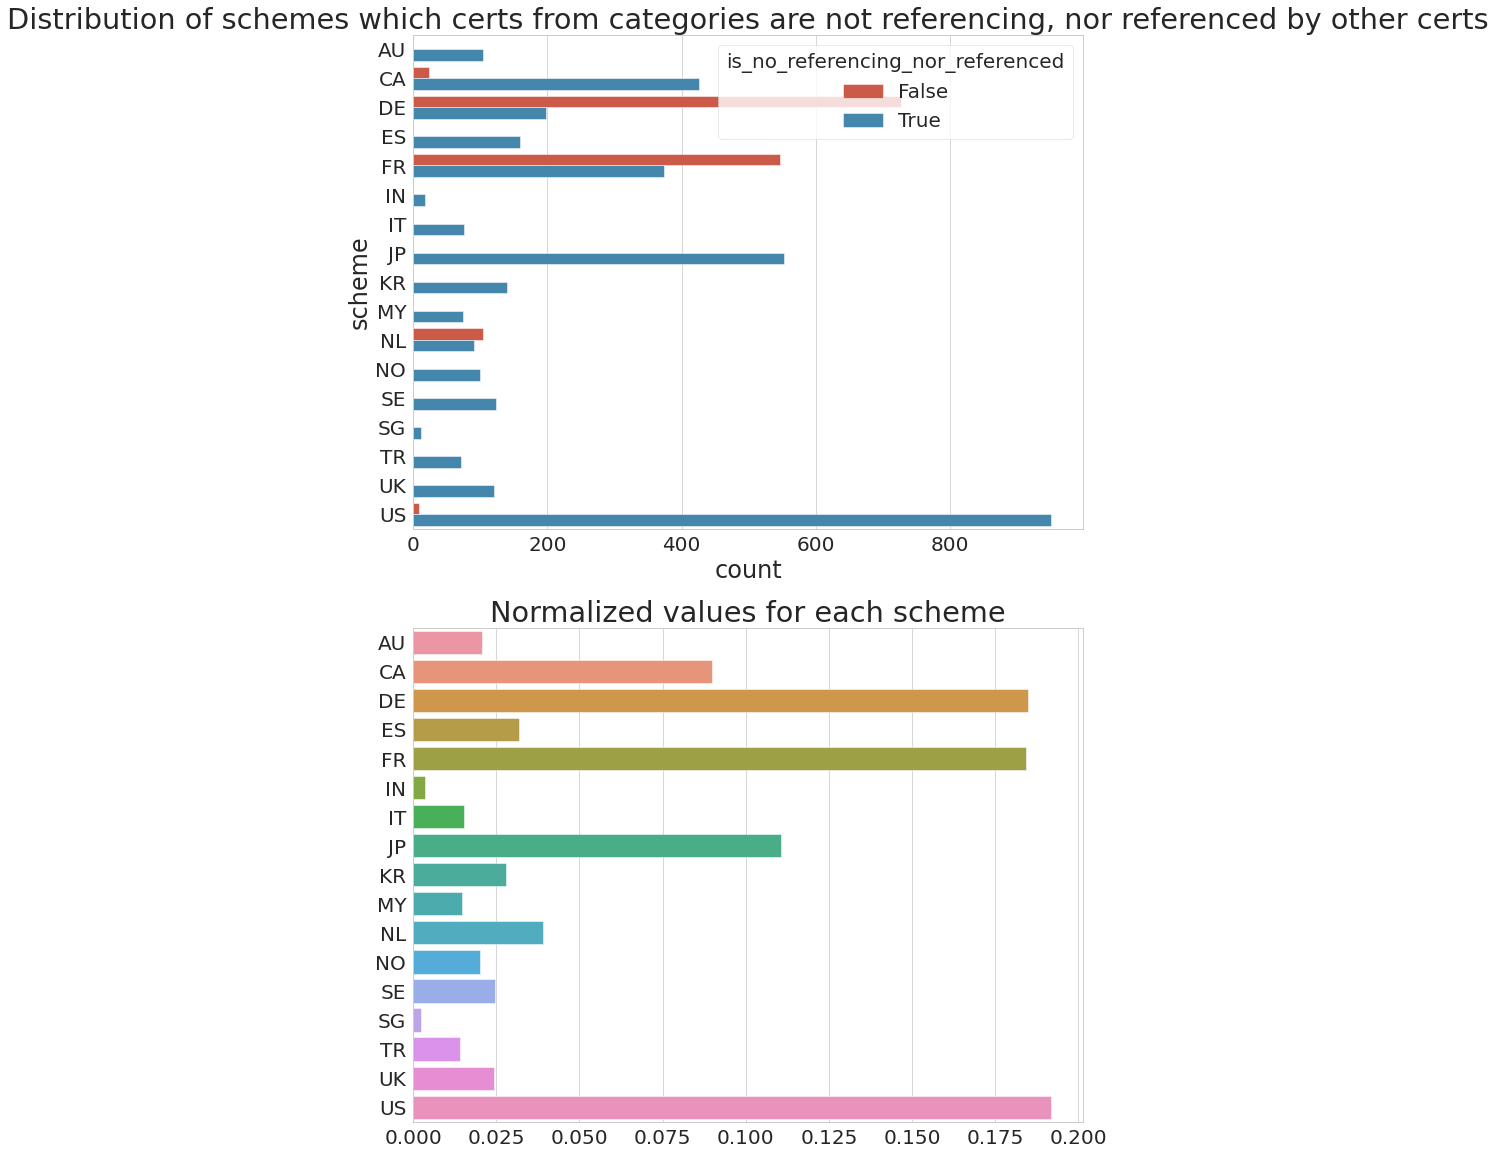

In [28]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = no_affecting_no_affected_df["scheme"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="scheme", hue="is_no_referencing_nor_referenced", data=no_affecting_no_affected_df, ax=ax1).set_title("Distribution of schemes which certs from categories are not referencing, nor referenced by other certs")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each scheme")
plt.show()

### Which certificates are dependent on the archived certificates?

In [29]:
archived_cert_id_list = df[df["cert_id"].notna() & (df["status"] == "archived")]["cert_id"].tolist()

def contains_archived_cert_dependency(affected_by):
    if affected_by is np.nan:
        return False
    
    for cert_id in affected_by:
        if cert_id in archived_cert_id_list:
            return True
        
    return False


depends_on_archived_df = df.copy()
depends_on_archived_df["referenced_by_archived"] = depends_on_archived_df["directly_referenced_by"].apply(contains_archived_cert_dependency)
total_records_dependent = sum(depends_on_archived_df["referenced_by_archived"])
print(f"Total {total_records_dependent} certificates are referenced by at least one archived certicates.")

Total 434 certificates are referenced by at least one archived certicates.


In [30]:
# How many ACTIVE certificates are directly referencing at least 1 archived certificate
from typing import Set

archived_cert_id_list = df[df["cert_id"].notna() & (df["status"] == "archived")]["cert_id"].tolist()


def is_referencing_archived(directly_affecting: Set[str]):
    if directly_affecting is np.nan:
        return False
    
    for cert_id in directly_affecting:
        if cert_id in archived_cert_id_list:
            return True
        
    return False

active_certs_df = df[(df["status"] == "active")].copy()
total_active_referencing_certs = sum(active_certs_df["directly_referencing"].notna())
active_certs_df["is_referencing_archived"] = active_certs_df["directly_referencing"].apply(is_referencing_archived)
total_active_certs_referencing_archived = sum(active_certs_df["is_referencing_archived"])

print(f"Out of {active_certs_df.shape[0]} active certificates, {total_active_referencing_certs} are referencing at least 1 certificate")
print(f"Out of {total_active_referencing_certs} referencing cert, {total_active_certs_referencing_archived} are referencing at least 1 already archived certificate")

Out of 1653 active certificates, 429 are referencing at least 1 certificate
Out of 429 referencing cert, 138 are referencing at least 1 already archived certificate


In [32]:
df[df["status"] == "active"].shape[0]

1653

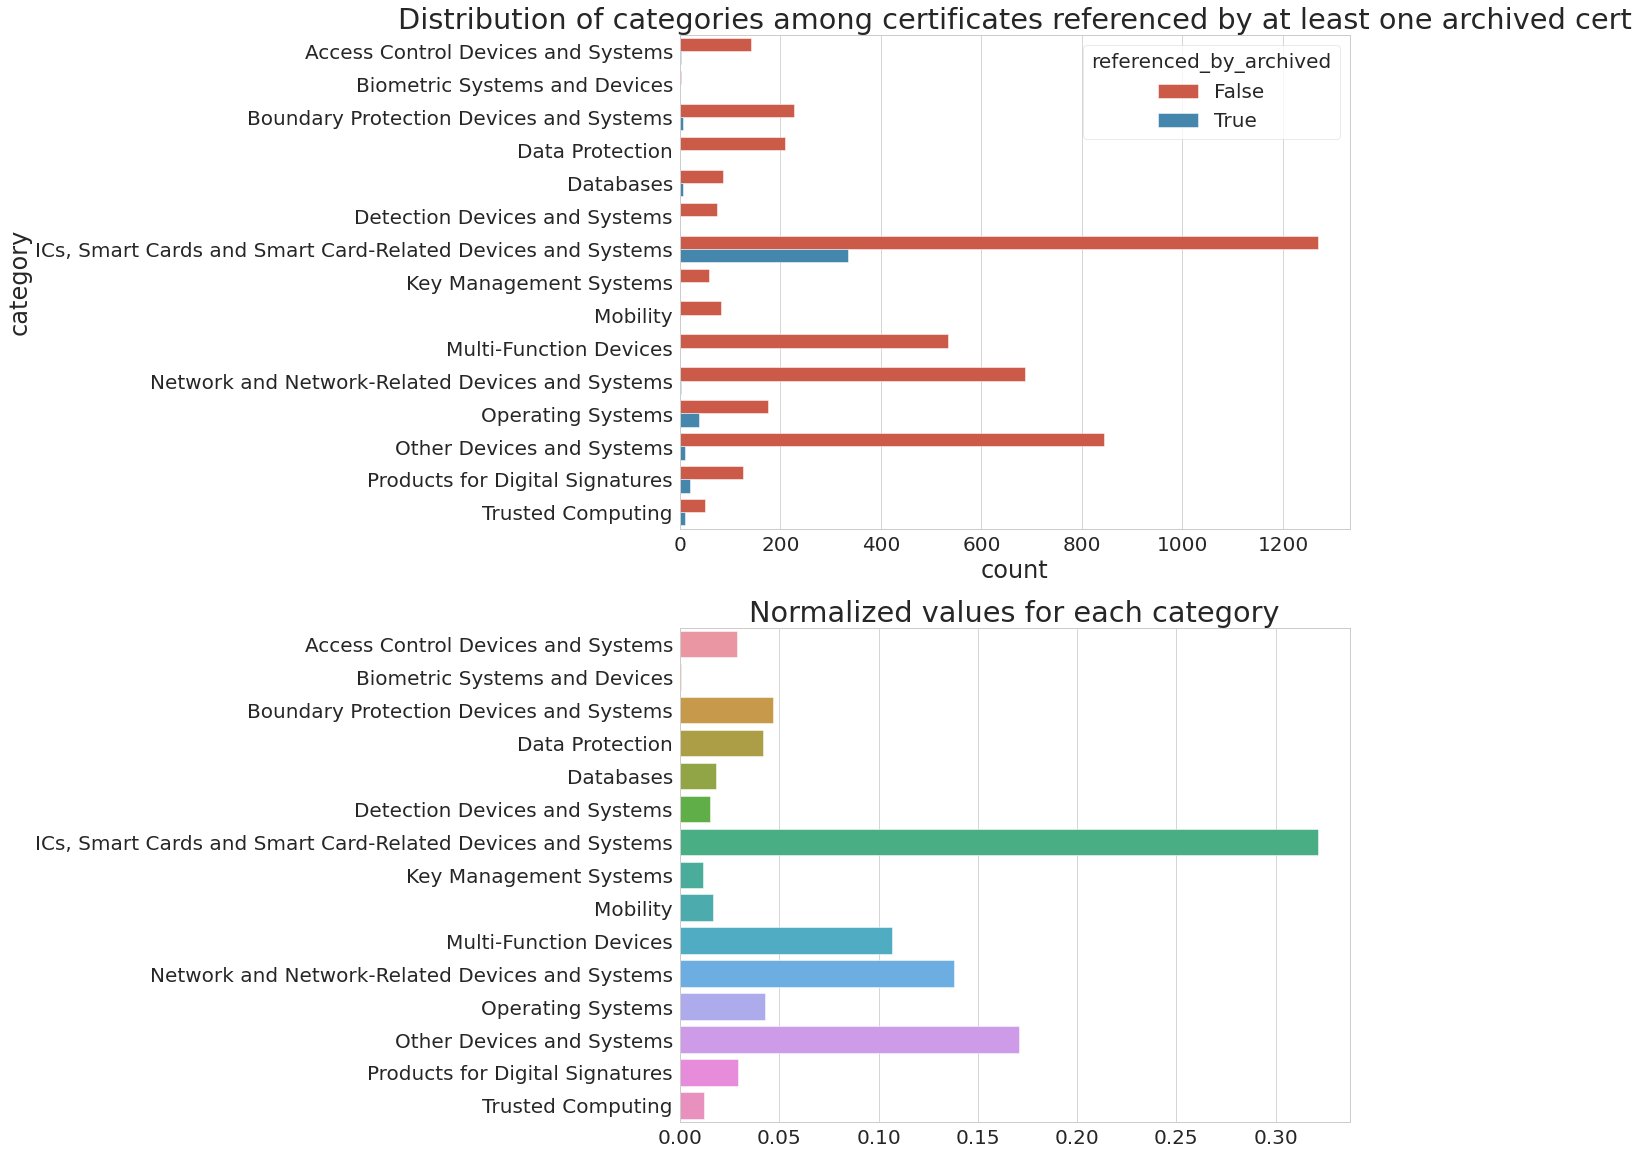

In [31]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = depends_on_archived_df["category"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="category", hue="referenced_by_archived", data=depends_on_archived_df, ax=ax1).set_title("Distribution of categories among certificates referenced by at least one archived cert")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each category")
plt.show()

### Distribution of schemes in the dataset with normalized subplot

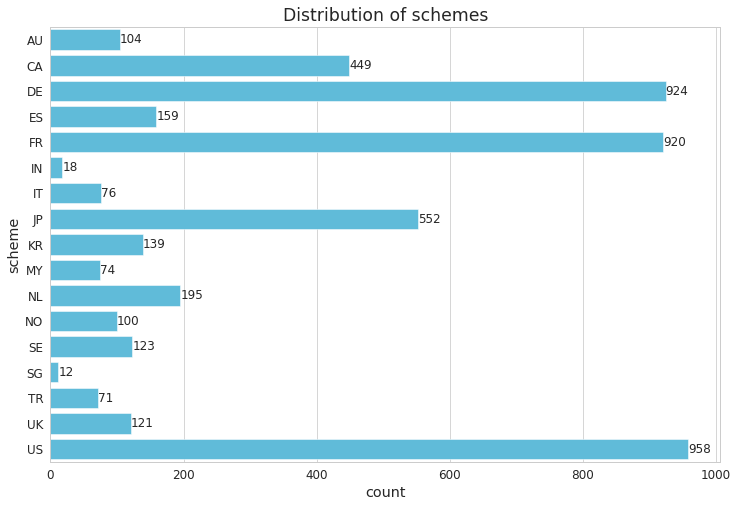

In [33]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 12})
ax = sns.countplot(y="scheme", data=df, color="blue", palette=['#4cc5ed'], )
plt.bar_label(ax.containers[0])
ax.set_title("Distribution of schemes")
plt.savefig("schemes_distribution.png")
plt.show()

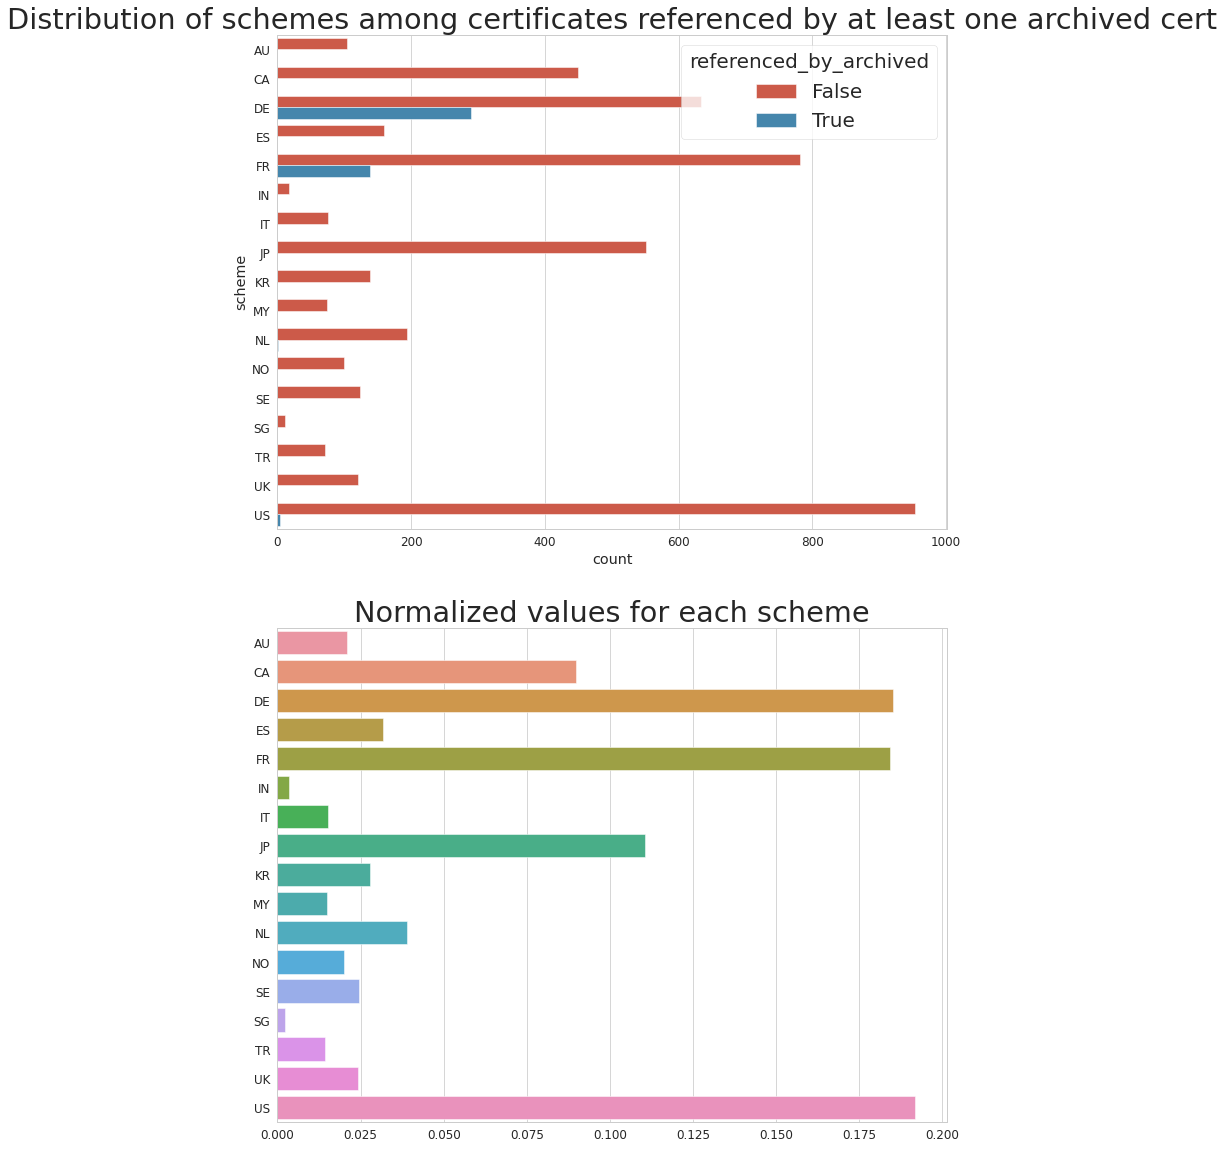

In [34]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = depends_on_archived_df["scheme"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="scheme", hue="referenced_by_archived", data=depends_on_archived_df, ax=ax1).set_title("Distribution of schemes among certificates referenced by at least one archived cert")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each scheme")
plt.show()

### BSI + NSCIB + ANSSI - references

In [35]:
from typing import Set
from enum import Enum


class CertType(Enum):
    BSI = "bsi"
    ANSSI = "anssi"
    NSCIB = "nscib"

    

def get_cert_type(cert_id):
    if cert_id is np.nan:
        return None
    
    if cert_id.lower().startswith(CertType.BSI.value):
        return CertType.BSI.value
    
    if cert_id.lower().startswith(CertType.ANSSI.value):
        return CertType.ANSSI.value
    
    if cert_id.lower().startswith(CertType.NSCIB.value):
        return CertType.NSCIB.value
    
    return None


def is_referencing_cert_type(directly_referencing_set: Set[str], cert_type: CertType) -> bool:
    if directly_referencing_set is np.nan:
        return False
    
    for cert_id in directly_referencing_set:
        if get_cert_type(cert_id) == cert_type.value:
            return True
        
    return False


def get_referencing_certs(dset, cert_type: CertType):
    total = 0
    
    for _, row in dset.iterrows():
        total += is_referencing_cert_type(row["directly_referencing"], cert_type)
    
    return total

df["cert_type"] = df["cert_id"].apply(get_cert_type)

bsi_df = df[df["cert_type"] == CertType.BSI.value].copy()
anssi_df = df[df["cert_type"] == CertType.ANSSI.value].copy()
nscib_df = df[df["cert_type"] == CertType.NSCIB.value].copy()

bsi_total_referencing = bsi_df[bsi_df["directly_referencing"].notna()].shape[0]
anssi_total_referencing = anssi_df[anssi_df["directly_referencing"].notna()].shape[0]
nscib_total_referencing = nscib_df[nscib_df["directly_referencing"].notna()].shape[0]

bsi_referencing_anssi_total = get_referencing_certs(bsi_df, CertType.ANSSI)
bsi_referencing_nscib_total = get_referencing_certs(bsi_df, CertType.NSCIB)

anssi_referencing_bsi_total = get_referencing_certs(anssi_df, CertType.BSI)
anssi_referencing_nscib_total = get_referencing_certs(anssi_df, CertType.NSCIB)

nscib_referencing_bsi = get_referencing_certs(nscib_df, CertType.BSI)
nscib_referencing_anssi = get_referencing_certs(nscib_df, CertType.ANSSI)

print(f"BSI: total of {bsi_df.shape[0]} records, {bsi_total_referencing} certificates reference at least one certificate")
print(f"Out of {bsi_total_referencing} certificates {bsi_referencing_anssi_total} reference at least 1 ANSSI certificate")
print(f"Out of {bsi_total_referencing} certificates {bsi_referencing_nscib_total} reference at least 1 NSCIB certificate")
print(f"Out of {bsi_total_referencing} certificates {get_referencing_certs(bsi_df, CertType.BSI)} reference at least 1 BSI certificate")

print()

print(f"ANSSI: total of {anssi_df.shape[0]} records, {anssi_total_referencing} certificates reference at least one certificate")
print(f"Out of {anssi_total_referencing} certificates {anssi_referencing_bsi_total} reference at least 1 BSI certificate")
print(f"Out of {anssi_total_referencing} certificates {anssi_referencing_nscib_total} reference at least 1 NSCIB certificate")
print(f"Out of {anssi_total_referencing} certificates {get_referencing_certs(anssi_df, CertType.ANSSI)} reference at least 1 ANSSI certificate")

print()

print(f"NSCIB: total of {nscib_df.shape[0]} records, {nscib_total_referencing} certificate reference at least one certificate")
print(f"Out of {nscib_total_referencing} certificates {nscib_referencing_bsi} reference at least 1 BSI certificate")
print(f"Out of {nscib_total_referencing} certificates {nscib_referencing_anssi} reference at least 1 ANSSI certificate")
print(f"Out of {nscib_total_referencing} certificates {get_referencing_certs(nscib_df, CertType.NSCIB)} reference at least 1 NSCIB certificate")

BSI: total of 944 records, 599 certificates reference at least one certificate
Out of 599 certificates 16 reference at least 1 ANSSI certificate
Out of 599 certificates 16 reference at least 1 NSCIB certificate
Out of 599 certificates 588 reference at least 1 BSI certificate

ANSSI: total of 725 records, 459 certificates reference at least one certificate
Out of 459 certificates 214 reference at least 1 BSI certificate
Out of 459 certificates 20 reference at least 1 NSCIB certificate
Out of 459 certificates 334 reference at least 1 ANSSI certificate

NSCIB: total of 185 records, 98 certificate reference at least one certificate
Out of 98 certificates 30 reference at least 1 BSI certificate
Out of 98 certificates 19 reference at least 1 ANSSI certificate
Out of 98 certificates 67 reference at least 1 NSCIB certificate


### Which certificates are referencing each other? (= are crossed referenced)

In [36]:
def is_already_involved(cross_reference_list: List[Tuple[str, str]], certs_set: Set[str]) -> bool:
    return certs_set in cross_reference_list

def is_cert_referencing_other_cert(root_cert_id: str, affected_cert_id: str) -> bool:
    return affected_cert_id in cross_df[cross_df["cert_id"] == root_cert_id].iloc[0]["directly_referencing"]

cross_reference_list: List[Set[str]] = []
cross_df = df[(df["cert_id"].notna()) & (df["directly_referencing"].notna())]
count = 1
total = cross_df.shape[0]

for cert_record in cross_df.itertuples():
    cert_id = cert_record.cert_id
    print(count)
    for another_cert_record in cross_df.itertuples():

        another_cert_id = another_cert_record.cert_id
        
        if cert_record.cert_id == another_cert_record.cert_id:
            continue
            
        certs_set = set([cert_id, another_cert_id])
        
        if is_cert_referencing_other_cert(cert_id, another_cert_id) and is_cert_referencing_other_cert(another_cert_id, cert_id) and not is_already_involved(cross_reference_list, certs_set):
            cross_reference_list.append(certs_set)
    count += 1 
    
    
print(f"Total of {len(cross_reference_list)} crossed referenced certificates.")
print(cross_reference_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


KeyboardInterrupt: 

### What are the EAL levels typically affecting a certificate? E.g. are certificates referencing EAL5 typically higher or same level?

In [37]:
df.head()

cert_id  \
dgst                                     
8298c7814b3b2860         KECS-CR-22-11   
9a1c767d358eee50  DXC-EFC-T092-ETR 1.0   
979e00ac7d3e229c         KECS-CR-21-63   
a6015339aa4434cf         KECS-CR-21-52   
a89ee15539d006d1           CSEC2019015   

                                                               name  status  \
dgst                                                                          
8298c7814b3b2860                                   KSignAccess V4.1  active   
9a1c767d358eee50    VeroGuard HSM Digital ID for Open Networks v1.0  active   
979e00ac7d3e229c                                  SafeIdentity v5.1  active   
a6015339aa4434cf                                     Bandi SSO v7.0  active   
a89ee15539d006d1  DriveLock Agent 2019.2 (Device and Application...  active   

                                            category  \
dgst                                                   
8298c7814b3b2860  Access Control Devices and Systems   
9a1c767d358eee50  Access Control Devices and Systems   
979e00ac7d3e229c  Access Control Devices and Systems   
a6015339aa4434cf  Access Control Devices and Systems   
a89ee15539d006d1  Access Control Devices and Systems   

                               manufacturer scheme cert_lab  \
dgst                                                          
8298c7814b3b2860            KSign Co., LTD.     KR      NaN   
9a1c767d358eee50  VeroGuard Systems Pty Ltd     AU      NaN   
979e00ac7d3e229c           Hancom With Inc.     KR      NaN   
a6015339aa4434cf                    Bandi S     KR      NaN   
a89ee15539d006d1               DriveLock SE     SE      NaN   

                      security_level not_valid_before not_valid_after  ...  \
dgst                                                                   ...   
8298c7814b3b2860                  {}       2022-03-30      2027-03-30  ...   
9a1c767d358eee50  {EAL2+, ALC_FLR.1}       2022-02-23      2027-02-23  ...   
979e00ac7d3e229c                  {}       2021-11-05      2026-11-05  ...   
a6015339aa4434cf                  {}       2021-09-08      2026-09-08  ...   
a89ee15539d006d1   {EAL3, ALC_FLR.3}       2021-04-07      2026-04-07  ...   

                 cpe_matches verified_cpe_matches related_cves  \
dgst                                                             
8298c7814b3b2860         NaN                  NaN          NaN   
9a1c767d358eee50         NaN                  NaN          NaN   
979e00ac7d3e229c         NaN                  NaN          NaN   
a6015339aa4434cf         NaN                  NaN          NaN   
a89ee15539d006d1         NaN                  NaN          NaN   

                 directly_referenced_by indirectly_referenced_by  \
dgst                                                               
8298c7814b3b2860                    NaN                      NaN   
9a1c767d358eee50                    NaN                      NaN   
979e00ac7d3e229c                    NaN                      NaN   
a6015339aa4434cf                    NaN                      NaN   
a89ee15539d006d1                    NaN                      NaN   

                  directly_referencing indirectly_referencing  \
dgst                                                            
8298c7814b3b2860                   NaN                    NaN   
9a1c767d358eee50                   NaN                    NaN   
979e00ac7d3e229c                   NaN                    NaN   
a6015339aa4434cf                   NaN                    NaN   
a89ee15539d006d1                   NaN                    NaN   

                 direct_dependency_cves indirect_dependency_cves cert_type  
dgst                                                                        
8298c7814b3b2860                    NaN                      NaN       NaN  
9a1c767d358eee50                    NaN                      NaN       NaN  
979e00ac7d3e229c                    NaN                      NaN       NaN  
a6015339aa4434cf   

In [38]:
# Introduce security level EAL variable
CC_EALS = ['EAL1', 'EAL1+', 'EAL2', 'EAL2+', 'EAL3', 'EAL3+', 'EAL4', 'EAL4+', 'EAL5', 'EAL5+', 'EAL6+', 'EAL7', 'EAL7+']
df['highest_security_level'] = df.security_level.map(lambda levels_dict: [eal for eal in levels_dict if eal.startswith('EAL')] if levels_dict else np.nan)
df.highest_security_level = df.highest_security_level.map(lambda x: x[0] if x and isinstance(x, list) else np.nan)
df.highest_security_level = pd.Categorical(df.highest_security_level, categories=CC_EALS, ordered=True)

In [39]:
levels_df = df[(df["highest_security_level"].notna()) & (df["directly_referencing"].notna()) & (df["cert_id"].notna())].copy()
levels_df.head()

cert_id  \
dgst                                        
98c1ac41aedcdae2     BSI-DSZ-CC-1142-2020   
0eff4063e68d7cd6     BSI-DSZ-CC-0823-2014   
47750cedacaaf370     NSCIB-CC-12-34853-CR   
9b5f007978a96739     NSCIB-CC-11-34146-CR   
5a12431e371f3ce9  BSI-DSZ-CC-0961-V6-2022   

                                                               name  status  \
dgst                                                                          
98c1ac41aedcdae2                                     genuscreen 7.0  active   
0eff4063e68d7cd6                                     genuscreen 4.0  active   
47750cedacaaf370                 Nexor Sentinel 3E Filtering System  active   
9b5f007978a96739  Waterfall Unidirectional Security Gateway mode...  active   
5a12431e371f3ce9  Infineon Security Controller IFX_CCI_000007h, ...  active   

                                                           category  \
dgst                                                                  
98c1ac41aedcdae2            Boundary Protection Devices and Systems   
0eff4063e68d7cd6            Boundary Protection Devices and Systems   
47750cedacaaf370            Boundary Protection Devices and Systems   
9b5f007978a96739            Boundary Protection Devices and Systems   
5a12431e371f3ce9  ICs, Smart Cards and Smart Card-Related Device...   

                                       manufacturer scheme cert_lab  \
dgst                                                                  
98c1ac41aedcdae2                         genua GmbH     DE    [BSI]   
0eff4063e68d7cd6                          GeNUA mbH     DE    [BSI]   
47750cedacaaf370                         Nexor Ltd.     NL       []   
9b5f007978a96739  Waterfall Security Solutions Ltd.     NL       []   
5a12431e371f3ce9           Infineon Technologies AG     DE    [BSI]   

                                            security_level not_valid_before  \
dgst                                                                          
98c1ac41aedcdae2  {AVA_VAN.4, ALC_FLR.2, ASE_TSS.2, EAL4+}       2020-08-18   
0eff4063e68d7cd6  {AVA_VAN.4, ALC_FLR.2, ASE_TSS.2, EAL4+}       2014-10-29   
47750cedacaaf370                        {ALC_FLR.2, EAL4+}       2012-12-21   
9b5f007978a96739  {ALC_DVS.2, EAL4+, AVA_VAN.5, ALC_FLR.2}       2012-07-12   
5a12431e371f3ce9                        {ALC_FLR.1, EAL6+}       2022-03-23   

                 not_valid_after  ... verified_cpe_matches related_cves  \
dgst                              ...                                     
98c1ac41aedcdae2      2025-08-17  ...                  NaN          NaN   
0eff4063e68d7cd6             NaT  ...                  NaN          NaN   
47750cedacaaf370      2022-12-21  ...                  NaN          NaN   
9b5f007978a96739      2022-07-12  ...                  NaN          NaN   
5a12431e371f3ce9      2027-03-23  ...                  NaN          NaN   

                  directly_referenced_by indirectly_referenced_by  \
dgst                                                                
98c1ac41aedcdae2                     NaN                      NaN   
0eff4063e68d7cd6  {BSI-DSZ-CC-0966-2015}   {BSI-DSZ-CC-0966-2015}   
47750cedacaaf370                     NaN                      NaN   
9b5f007978a96739                     NaN                      NaN   
5a12431e371f3ce9                     NaN                      NaN   

                       directly_referencing  \
dgst                                          
98c1ac41aedcdae2     {BSI-DSZ-CC-1085-2019}   
0eff4063e68d7cd6     {BSI-DSZ-CC-0565-2009}   
47750cedacaaf370        {NSCIB-CC-12-34853}   
9b5f007978a96739        {NSCIB-CC-11-34146}   
5a12431e371f3ce9  {BSI-DSZ-CC-0961-V5-2020}   

                                             indirectly_referencing  \
dgst                                                                  
98c1ac41aedcdae2                             {BSI-DSZ-CC-1085-2019}   
0eff4063e68d7cd6       {BSI-DSZ-CC-0382-2007, BSI-DSZ-CC-0565

In [40]:
from typing import Dict

def get_cert_id_security_level(cert_id: str) -> str:
    cert_id_df = df[df["cert_id"] == cert_id]
    
    if cert_id_df.empty:  # we do not have record in main dset for this cert_id
        return None
    
    return cert_id_df.iloc[0]["highest_security_level"]


def get_levels_of_affected_certs(affected_certs: Set[str]) -> Dict[str, int]:
    result = {}
    
    for affected_cert_id in affected_certs:
        security_level = get_cert_id_security_level(affected_cert_id)
        
        if security_level is None:  # cert_id does not follow condition for levels_df
            continue
            
        result[security_level] = result.get(security_level, 0) + 1
        
    return result


levels_df["referencing_security_levels"] = levels_df["directly_referencing"].apply(get_levels_of_affected_certs)
levels_df.head(20)

cert_id  \
dgst                                        
98c1ac41aedcdae2     BSI-DSZ-CC-1142-2020   
0eff4063e68d7cd6     BSI-DSZ-CC-0823-2014   
47750cedacaaf370     NSCIB-CC-12-34853-CR   
9b5f007978a96739     NSCIB-CC-11-34146-CR   
5a12431e371f3ce9  BSI-DSZ-CC-0961-V6-2022   
86e9da10bc176267      NSCIB-CC-0434407-CR   
185aa4f76ff15d62     BSI-DSZ-CC-1172-2022   
b4a2999b439b1ba8  BSI-DSZ-CC-1178-V2-2022   
0ce083454814c1ba  BSI-DSZ-CC-1179-V2-2022   
ac1257069b2f4afd  BSI-DSZ-CC-1113-V3-2022   
0f3900cdcd0c7f3e      NSCIB-CC-127667-CR3   
2be10f342e68a89e  BSI-DSZ-CC-0963-V3-2021   
7d8dc0575933f142  BSI-DSZ-CC-1025-V4-2021   
5eda77c801e2df86  BSI-DSZ-CC-0891-V6-2021   
65a47f93451f13de  BSI-DSZ-CC-1079-V3-2021   
723ba544431f7874     BSI-DSZ-CC-1162-2021   
84c868322995b179  BSI-DSZ-CC-0951-V5-2021   
e9c5d02aae54cdc5  BSI-DSZ-CC-0891-V5-2021   
b8370ceababbca40     NSCIB-CC-0089911-CR2   
e38c6956b53dfd36     NSCIB-CC-0089864-CR2   

                                                               name  status  \
dgst                                                                          
98c1ac41aedcdae2                                     genuscreen 7.0  active   
0eff4063e68d7cd6                                     genuscreen 4.0  active   
47750cedacaaf370                 Nexor Sentinel 3E Filtering System  active   
9b5f007978a96739  Waterfall Unidirectional Security Gateway mode...  active   
5a12431e371f3ce9  Infineon Security Controller IFX_CCI_000007h, ...  active   
86e9da10bc176267                   STMicroelectronics JSIGN4 V1.0.4  active   
185aa4f76ff15d62                          CardOS V6.0 ID R1.0 (BAC)  active   
b4a2999b439b1ba8  Infineon Technologies AG OPTIGA™ Trusted Platf...  active   
0ce083454814c1ba  Infineon Technologies AG OPTIGA™ Trusted Platf...  active   
ac1257069b2f4afd  Infineon Technologies AG OPTIGA™ Trusted Platf...  active   
0f3900cdcd0c7f3e                       EP-COS V3.0 Plain, EPCOSV30e  active   
2be10f342e68a89e  Infineon smartcard IC (Security Controller) M7...  active   
7d8dc0575933f142  Infineon smart card IC (Security Controller) I...  active   
5eda77c801e2df86  Infineon Security Controller M7892 Design Step...  active   
65a47f93451f13de  Infineon Security Controller IFX_CCI_00000Fh, ...  active   
723ba544431f7874                                CardOS V6.0 ID R1.0  active   
84c868322995b179  Infineon Security Controller M5073 G11 with sp...  active   
e9c5d02aae54cdc5  Infineon Security Controller M7892 Design Step...  active   
b8370ceababbca40       Thales CSP CSP v1.0 on Upteq NFC422 v1.0 JCS  active   
e38c6956b53dfd36                             Thales NFC422 v1.0 JCS  active   

                                                           category  \
dgst                                                                  
98c1ac41aedcdae2            Boundary Protection Devices and Systems   
0eff4063e68d7cd6            Boundary Protection Devices and Systems   
47750cedacaaf370            Boundary Protection Devices and Systems   
9b5f007978a96739            Boundary Protection Devices and Systems   
5a12431e371f3ce9  ICs, Smart Cards and Smart Card-Related Device...   
86e9da10bc176267  ICs, Smart Cards and Smart Card-Related Device...   
185aa4f76ff15d62  ICs, Smart Cards and Smart Card-Related Device...   
b4a2999b439b1ba8  ICs, Smart Cards and Smart Card-Related Device...   
0ce083454814c1ba  ICs, Smart Cards and Smart Card-Related Device...   
ac1257069b2f4afd  ICs, Smart Cards and Smart Card-Related Device...   
0f3900cdcd0c7f3e  ICs, Smart Cards and Smart Card-Related Device...   
2be10f342e68a89e  ICs, Smart Cards and Smart Card-Related Device...   
7d8dc0575933f142  ICs, Smart Cards and Smart Card-Related Device...   
5eda77c801e2df86  ICs, Smart Cards and Smart Card-Related Device...   
65a47f93451f13de  ICs, Smart Cards and Smart Card-Related Device...   
723ba544431f7874  ICs, Smart Cards and Smart Card-Related Device...   
84c868322995b179  ICs, Sma

In [41]:
security_level_references = {}

for security_level in CC_EALS:
    security_level_list = []
    counter = collections.Counter()
    security_level_df = levels_df[levels_df["highest_security_level"] == security_level]["referencing_security_levels"]
    
    for security_dict in security_level_df:
        counter.update(security_dict)
                
    print(f"Certs with security level {security_level} are directly referencing other certificates with levels: {dict(counter)}")
        
    security_level_references[security_level] = counter

Certs with security level EAL1 are directly referencing other certificates with levels: {'EAL4+': 1}
Certs with security level EAL1+ are directly referencing other certificates with levels: {}
Certs with security level EAL2 are directly referencing other certificates with levels: {'EAL2': 7, 'EAL2+': 1, 'EAL4+': 1, 'EAL5+': 1}
Certs with security level EAL2+ are directly referencing other certificates with levels: {'EAL2': 5, 'EAL2+': 11, 'EAL4+': 1}
Certs with security level EAL3 are directly referencing other certificates with levels: {'EAL3': 10, 'EAL5+': 1}
Certs with security level EAL3+ are directly referencing other certificates with levels: {'EAL3+': 22, 'EAL3': 3, 'EAL4+': 1}
Certs with security level EAL4 are directly referencing other certificates with levels: {'EAL6+': 3, 'EAL5+': 2, 'EAL4+': 5, 'EAL4': 6}
Certs with security level EAL4+ are directly referencing other certificates with levels: {'EAL4+': 396, 'EAL5+': 388, 'EAL6+': 76, 'EAL4': 2, 'EAL3+': 4, 'EAL5': 4, 'EAL3

#### Graph for references among security levels

In [42]:
plot_graphviz_graph(title="References among EALs", 
                    filename="security_level_references", 
                    nodes=CC_EALS, 
                    data_dict=security_level_references)

security_level_references has been rendered successfully


#### Plotly barplot of references among security levels

In [43]:
make_stacked_bar_plot(security_level_references, 
                      title="References among security levels", 
                      xaxis_label="EALs", 
                      yaxis_label="Count",
                      category_orders=CC_EALS)

In [44]:
make_heatmap_plot(security_level_references, 
                  title="References among security levels",
                  xaxis_label="Referenced Security Level",
                  yaxis_label="Referencing Security Level",
                  category_orders=CC_EALS)

In [46]:
total = 0


for key in security_level_references:
    for ref_key in security_level_references[key]:
        if ref_key is not None:
            total += security_level_references[key][ref_key]
            
print(f"Total of {total} references among security levels")

Total of 1713 references among security levels


In [47]:
# Security levels in each category
fig = px.density_heatmap(df, x="category", y="highest_security_level", color_continuous_scale='Blues', 
            text_auto=True, category_orders={"highest_security_level": CC_EALS})
fig.show()

### Basic Analysis of most common category

In [48]:
cards_df = df[df["category"] == "ICs, Smart Cards and Smart Card-Related Devices and Systems"]
print(f"There are total {cards_df.shape[0]} rows ICs, Smart Cards and Smart Card-Related Devices and Systems category.")

There are total 1604 rows ICs, Smart Cards and Smart Card-Related Devices and Systems category.


#### How many certificates are active/archived

In [49]:
total_archived_certs = sum(cards_df["status"] == "archived")
total_active_certs = sum(cards_df["status"] == "active")

print(f"There are total {total_archived_certs} archived records among smart-cards")
print(f"There are total {total_active_certs} active records among smart-cards")

There are total 1027 archived records among smart-cards
There are total 577 active records among smart-cards


#### Which manufacturer is the most common in this category?

In [50]:
most_common_smart_card_manufacturer = cards_df["manufacturer"].value_counts().index[0]
print(f"The most common manufacturer in smart cards category is: {most_common_smart_card_manufacturer}")

The most common manufacturer in smart cards category is: Infineon Technologies AG


#### Analysis of security levels of smart-cards

In [51]:
# The most common security level among smart-cards
most_common_sec_level = cards_df["highest_security_level"].value_counts().index[0]
sec_level_amount = cards_df["highest_security_level"].value_counts()[0]

print(f"Most common security level among smart-cards is {most_common_sec_level} with {sec_level_amount} occurences.")

Most common security level among smart-cards is EAL5+ with 716 occurences.


In [52]:
# The lowest common security level achieved in dataset
security_level_occurences = cards_df["highest_security_level"].value_counts()
filtered_sec_levels = [sec_level for sec_level, count in security_level_occurences.items() if count > 0]
level_numbers = {x: y for x, y in zip(CC_EALS, range(len(CC_EALS)))}

lowest_smart_card_security_level = None
lowest_security_level_int = None

for sec_level in filtered_sec_levels:
    if lowest_security_level_int is None:
        lowest_security_level_int = level_numbers[sec_level]
        lowest_smart_card_security_level = sec_level
    
    if level_numbers[sec_level] < lowest_security_level_int:
        lowest_security_level_int = level_numbers[sec_level]
        lowest_smart_card_security_level = sec_level
        
print(f"Lowest security level among smart cards in dataset: {lowest_smart_card_security_level}")

Lowest security level among smart cards in dataset: EAL1+


In [53]:
# The highest common security level in smart-card dataset
highest_smart_card_security_level = None
highest_security_level_int = None

for sec_level in filtered_sec_levels:
    if highest_security_level_int is None:
        highest_security_level_int = level_numbers[sec_level]
        highest_smart_card_security_level = sec_level
    
    if level_numbers[sec_level] > highest_security_level_int:
        highest_security_level_int = level_numbers[sec_level]
        highest_smart_card_security_level = sec_level
        
print(f"Highest security level among smart cards in dataset: {highest_smart_card_security_level}")

Highest security level among smart cards in dataset: EAL7


#### View data with lowest security level (EAL1+)

In [54]:
eal1_plus_df = cards_df[cards_df["highest_security_level"] == "EAL1+"]
eal1_plus_df.head()

cert_id  \
dgst                                                 
be0806db6fd6bbe8  Rapport de certification 2001/14   
1a95d138ccc7814a  Rapport de certification 2001/16   
35ac4cfd1f62df75  Rapport de certification 2001/22   
7c062b969e50e2af  Rapport de certification 2001/20   
f66157c81ab85729  Rapport de certification 2001/03   

                                                               name    status  \
dgst                                                                            
be0806db6fd6bbe8  ATMEL AT90SC6464C Integrated circuit (referenc...  archived   
1a95d138ccc7814a  CT2000 embedded Component (reference ST16RFHD5...  archived   
35ac4cfd1f62df75                 M/Chip Select v2.0.5.2 Application  archived   
7c062b969e50e2af  MODEUS electronic purse : MODEUS carrier card ...  archived   
f66157c81ab85729  Oberthur B0' application v1.0.1 and GemClub v1...  archived   

                                                           category  \
dgst                                                                  
be0806db6fd6bbe8  ICs, Smart Cards and Smart Card-Related Device...   
1a95d138ccc7814a  ICs, Smart Cards and Smart Card-Related Device...   
35ac4cfd1f62df75  ICs, Smart Cards and Smart Card-Related Device...   
7c062b969e50e2af  ICs, Smart Cards and Smart Card-Related Device...   
f66157c81ab85729  ICs, Smart Cards and Smart Card-Related Device...   

                                                   manufacturer scheme  \
dgst                                                                     
be0806db6fd6bbe8                           ATMEL Smart Card ICs     FR   
1a95d138ccc7814a                                            ASK     FR   
35ac4cfd1f62df75                       Mondex International Ltd     FR   
7c062b969e50e2af                   ASK, CP8, STMicroelectronics     FR   
f66157c81ab85729  Oberthur Card Systems, Gemplus, Trusted Logic     FR   

                 cert_lab      security_level not_valid_before  \
dgst                                                             
be0806db6fd6bbe8      NaN  {AVA_VLA.2, EAL1+}       2001-01-01   
1a95d138ccc7814a      NaN  {AVA_VLA.2, EAL1+}       2001-01-01   
35ac4cfd1f62df75      NaN  {AVA_VLA.2, EAL1+}       2001-01-01   
7c062b969e50e2af      NaN  {AVA_VLA.2, EAL1+}       2001-01-01   
f66157c81ab85729      NaN  {AVA_VLA.2, EAL1+}       2001-01-01   

                 not_valid_after  ... verified_cpe_matches related_cves  \
dgst                              ...                                     
be0806db6fd6bbe8      2019-09-01  ...                  NaN          NaN   
1a95d138ccc7814a      2019-09-01  ...                  NaN          NaN   
35ac4cfd1f62df75      2019-09-01  ...                  NaN          NaN   
7c062b969e50e2af      2019-09-01  ...                  NaN          NaN   
f66157c81ab85729      2019-09-01  ...                  NaN          NaN   

                 directly_referenced_by indirectly_referenced_by  \
dgst                                                               
be0806db6fd6bbe8                    NaN                      NaN   
1a95d138ccc7814a                    NaN                      NaN   
35ac4cfd1f62df75                    NaN                      NaN   
7c062b969e50e2af                    NaN                      NaN   
f66157c81ab85729                    NaN                      NaN   

                 directly_referencing  indirectly_referencing  \
dgst                                                            
be0806db6fd6bbe8                  NaN                     NaN   
1a95d138ccc7814a                  NaN                     NaN   
35ac4cfd1f62df75                  NaN                     NaN   
7c062b969e50e2af                  NaN                     NaN   
f66157c81ab85729                  NaN                     NaN   

                 direct_dependency_cves indirect_dependency_cves cert_type  \
dgst                                                                         
b

In [64]:
eal1_plus_df["scheme"].value_counts()

FR    14
AU     0
MY     0
UK     0
TR     0
SG     0
SE     0
NO     0
NL     0
KR     0
CA     0
JP     0
IT     0
IN     0
ES     0
DE     0
US     0
Name: scheme, dtype: int64

#### View data with highest security level (EAL7)

In [65]:
eal7_df = cards_df[cards_df["highest_security_level"] == highest_smart_card_security_level]
eal7_df.head()

cert_id  \
dgst                                 
8ee7145a1b48b578  ANSSI-CC-2020/33   
d08b5ddedd34448d  ANSSI-CC-2018/50   
ff45605151ec4eb1  ANSSI-CC-2013/40   
9231adbf747903df  ANSSI-CC-2013/12   
890f788a91fc2fa1  ANSSI-CC-2013/11   

                                                               name    status  \
dgst                                                                            
8ee7145a1b48b578               MultiApp V4 JavaCard Virtual Machine    active   
d08b5ddedd34448d  IDMotion V2 Multos Virtual Machine OS Multos V...    active   
ff45605151ec4eb1  Virtual Machine of Multos M3 G230M mask with A...  archived   
9231adbf747903df  Memory Management Unit des microcontrôleurs SA...  archived   
890f788a91fc2fa1  Virtual Machine of ID Motion V1 G231 mask with...  archived   

                                                           category  \
dgst                                                                  
8ee7145a1b48b578  ICs, Smart Cards and Smart Card-Related Device...   
d08b5ddedd34448d  ICs, Smart Cards and Smart Card-Related Device...   
ff45605151ec4eb1  ICs, Smart Cards and Smart Card-Related Device...   
9231adbf747903df  ICs, Smart Cards and Smart Card-Related Device...   
890f788a91fc2fa1  ICs, Smart Cards and Smart Card-Related Device...   

                                                  manufacturer scheme  \
dgst                                                                    
8ee7145a1b48b578                                       Gemalto     FR   
d08b5ddedd34448d                        Gemalto / Trusted Labs     FR   
ff45605151ec4eb1           Multos international / Trusted Labs     FR   
9231adbf747903df  Samsung Electronics Co., Ltd. / Trusted Labs     FR   
890f788a91fc2fa1                        Gemalto / Trusted Labs     FR   

                  cert_lab security_level not_valid_before not_valid_after  \
dgst                                                                         
8ee7145a1b48b578   [SERMA]         {EAL7}       2020-05-28      2025-05-28   
d08b5ddedd34448d  [THALES]         {EAL7}       2018-12-14      2023-12-14   
ff45605151ec4eb1       NaN         {EAL7}       2013-07-04      2019-09-01   
9231adbf747903df       NaN         {EAL7}       2013-03-29      2019-09-01   
890f788a91fc2fa1       NaN         {EAL7}       2013-03-29      2019-09-01   

                  ... verified_cpe_matches related_cves  \
dgst              ...                                     
8ee7145a1b48b578  ...                  NaN          NaN   
d08b5ddedd34448d  ...                  NaN          NaN   
ff45605151ec4eb1  ...                  NaN          NaN   
9231adbf747903df  ...                  NaN          NaN   
890f788a91fc2fa1  ...                  NaN          NaN   

                 directly_referenced_by indirectly_referenced_by  \
dgst                                                               
8ee7145a1b48b578                    NaN                      NaN   
d08b5ddedd34448d                    NaN                      NaN   
ff45605151ec4eb1                    NaN                      NaN   
9231adbf747903df                    NaN                      NaN   
890f788a91fc2fa1                    NaN                      NaN   

                                               directly_referencing  \
dgst                                                                  
8ee7145a1b48b578  {ANSSI-CC-2017/76, BSI-DSZ-CC-0891-V4-2019, AN...   
d08b5ddedd34448d           {BSI-DSZ-CC-0945-2017, ANSSI-CC-2018/35}   
ff45605151ec4eb1                                                NaN   
9231adbf747903df                                                NaN   
890f788a91fc2fa1                                                NaN   

                                             indirectly_referencing  \
dgst                                                                  
8ee7145a1b48b578  {BSI-DSZ-CC-0782-2012, ANSSI-CC-2017/76-S01, A...   
d08b5ddedd34448d  {BSI-DSZ-CC-094

In [66]:
eal7_df["scheme"].value_counts()

FR    6
AU    0
MY    0
UK    0
TR    0
SG    0
SE    0
NO    0
NL    0
KR    0
CA    0
JP    0
IT    0
IN    0
ES    0
DE    0
US    0
Name: scheme, dtype: int64

In [67]:
eal7_df[eal7_df["status"] == "active"]

cert_id  \
dgst                                 
8ee7145a1b48b578  ANSSI-CC-2020/33   
d08b5ddedd34448d  ANSSI-CC-2018/50   

                                                               name  status  \
dgst                                                                          
8ee7145a1b48b578               MultiApp V4 JavaCard Virtual Machine  active   
d08b5ddedd34448d  IDMotion V2 Multos Virtual Machine OS Multos V...  active   

                                                           category  \
dgst                                                                  
8ee7145a1b48b578  ICs, Smart Cards and Smart Card-Related Device...   
d08b5ddedd34448d  ICs, Smart Cards and Smart Card-Related Device...   

                            manufacturer scheme  cert_lab security_level  \
dgst                                                                       
8ee7145a1b48b578                 Gemalto     FR   [SERMA]         {EAL7}   
d08b5ddedd34448d  Gemalto / Trusted Labs     FR  [THALES]         {EAL7}   

                 not_valid_before not_valid_after  ... verified_cpe_matches  \
dgst                                               ...                        
8ee7145a1b48b578       2020-05-28      2025-05-28  ...                  NaN   
d08b5ddedd34448d       2018-12-14      2023-12-14  ...                  NaN   

                 related_cves directly_referenced_by indirectly_referenced_by  \
dgst                                                                            
8ee7145a1b48b578          NaN                    NaN                      NaN   
d08b5ddedd34448d          NaN                    NaN                      NaN   

                                               directly_referencing  \
dgst                                                                  
8ee7145a1b48b578  {ANSSI-CC-2017/76, BSI-DSZ-CC-0891-V4-2019, AN...   
d08b5ddedd34448d           {BSI-DSZ-CC-0945-2017, ANSSI-CC-2018/35}   

                                             indirectly_referencing  \
dgst                                                                  
8ee7145a1b48b578  {BSI-DSZ-CC-0782-2012, ANSSI-CC-2017/76-S01, A...   
d08b5ddedd34448d  {BSI-DSZ-CC-0945-2017, BSI-DSZ-CC-0782-2012, A...   

                 direct_dependency_cves indirect_dependency_cves cert_type  \
dgst                                                                         
8ee7145a1b48b578                    NaN                      NaN     anssi   
d08b5ddedd34448d                    NaN                      NaN     anssi   

                 highest_security_level  
dgst                                     
8ee7145a1b48b578                   EAL7  
d08b5ddedd34448d                   EAL7  

[2 rows x 25 columns]

#### Smarts cards which expires next year


In [68]:
next_year = datetime.datetime.now().year + 1

def is_expiring_next_year(series_datetime):
    return series_datetime.year == next_year


cards_next_year_expires_df = cards_df[cards_df["not_valid_after"].apply(is_expiring_next_year)]
cards_next_year_expires_df.head()

cert_id  \
dgst                                    
c5e25f90c7006546                  NaN   
744a7a202d909323                  NaN   
449c74a92ebb61a4                  NaN   
09b1192474bc8b27     ANSSI-CC-2018/32   
503a0d9db4445cbc  21.0.03/TSE-CCCS-64   

                                                               name  status  \
dgst                                                                          
c5e25f90c7006546  eTravel v2.3 on MultiApp v4.1 platform, BAC, E...  active   
744a7a202d909323  eTravel v2.3 on MultiApp v4.1 platform, BAC, E...  active   
449c74a92ebb61a4  eTravel v2.3 on MultiApp v4.1 platform, PACE, ...  active   
09b1192474bc8b27  Plateforme ouverte Java Card MultiApp V4.1 en ...  active   
503a0d9db4445cbc                                 Udea SSR_Core v1.0  active   

                                                           category  \
dgst                                                                  
c5e25f90c7006546  ICs, Smart Cards and Smart Card-Related Device...   
744a7a202d909323  ICs, Smart Cards and Smart Card-Related Device...   
449c74a92ebb61a4  ICs, Smart Cards and Smart Card-Related Device...   
09b1192474bc8b27  ICs, Smart Cards and Smart Card-Related Device...   
503a0d9db4445cbc  ICs, Smart Cards and Smart Card-Related Device...   

                                   manufacturer scheme cert_lab  \
dgst                                                              
c5e25f90c7006546           THALES DIS FRANCE SA     FR      NaN   
744a7a202d909323           THALES DIS FRANCE SA     FR      NaN   
449c74a92ebb61a4           THALES DIS FRANCE SA     FR      NaN   
09b1192474bc8b27           THALES DIS FRANCE SA     FR      NaN   
503a0d9db4445cbc  UDEA ELEKTRONİK SAN. TİC. A.Ş     TR      NaN   

                                                     security_level  \
dgst                                                                  
c5e25f90c7006546  {ALC_TAT.2, ALC_CMS.5, ADV_TDS.4, ATE_DPT.3, E...   
744a7a202d909323                      {EAL5+, ALC_DVS.2, AVA_VAN.5}   
449c74a92ebb61a4                                            {Basic}   
09b1192474bc8b27                      {EAL5+, ALC_DVS.2, AVA_VAN.5}   
503a0d9db4445cbc                                 {EAL4+, ALC_DVS.2}   

                 not_valid_before not_valid_after  ... verified_cpe_matches  \
dgst                                               ...                        
c5e25f90c7006546       2021-12-17      2023-12-12  ...                  NaN   
744a7a202d909323       2021-12-17      2023-12-12  ...                  NaN   
449c74a92ebb61a4       2021-12-17      2023-12-12  ...                  NaN   
09b1192474bc8b27       2021-10-08      2023-08-03  ...                  NaN   
503a0d9db4445cbc       2020-02-11      2023-02-11  ...                  NaN   

                 related_cves directly_referenced_by indirectly_referenced_by  \
dgst                                                                            
c5e25f90c7006546          NaN                    NaN                      NaN   
744a7a202d909323          NaN                    NaN                      NaN   
449c74a92ebb61a4          NaN                    NaN                      NaN   
09b1192474bc8b27          NaN                    NaN                      NaN   
503a0d9db4445cbc          NaN                    NaN                      NaN   

                 directly_referencing  indirectly_referencing  \
dgst                                                            
c5e25f90c7006546                  NaN                     NaN   
744a7a202d909323                  NaN                     NaN   
449c74a92ebb61a4                  NaN                     NaN   
09b1192474bc8b27                  NaN                     NaN   
503a0d9db4445cbc                  NaN                     NaN   

                 direct_dependency_cves indirect_dependency_cves cert_type  \
dgst                                                              

### Which schemes are directly affecting certs with other schemes

In [69]:
df["scheme"].value_counts()

US    958
DE    924
FR    920
JP    552
CA    449
NL    195
ES    159
KR    139
SE    123
UK    121
AU    104
NO    100
IT     76
MY     74
TR     71
IN     18
SG     12
Name: scheme, dtype: int64

In [56]:
scheme_df = df[df["directly_referencing"].notna()]
print(f"Total of {scheme_df.shape[0]} certs are directly referencing other certs.")

Total of 1213 certs are directly referencing other certs.


In [58]:
def get_scheme_from_cert_id(cert_id: str) -> str:
    scheme_list = df[df["cert_id"] == cert_id]["scheme"].tolist()
    
    if not scheme_list:
        return None 
    
    
    return df[df["cert_id"] == cert_id]["scheme"].tolist()[0]

### Graph for scheme dependencies


In [59]:
CC_SCHEMES = ["US", "FR", "DE", "JP", "CA", "NL", "ES", "KR", "UK", "AU", "NO", "SE", "MY", "TR", "IT", "IN", "SG"]
scheme_references = {}


for scheme in CC_SCHEMES:
    counter = collections.Counter()
    scheme_affecting_series = scheme_df[scheme_df["scheme"] == scheme]["directly_referencing"]
    
    for affecting_set in scheme_affecting_series:
        tmp_dict = {}
        
        for cert_id in affecting_set:
            current_scheme = get_scheme_from_cert_id(cert_id)
            tmp_dict[current_scheme] = tmp_dict.get(current_scheme, 0) + 1
            
        counter.update(tmp_dict)
    
    scheme_references[scheme] = counter 
    
scheme_references

{'US': Counter({'US': 2, None: 3}),
 'FR': Counter({'DE': 229, None: 196, 'FR': 463, 'KR': 43, 'ES': 7, 'NL': 21}),
 'DE': Counter({None: 134,
          'DE': 809,
          'FR': 19,
          'NL': 13,
          'KR': 20,
          'US': 2,
          'ES': 13,
          'TR': 7}),
 'JP': Counter(),
 'CA': Counter({None: 22, 'US': 1}),
 'NL': Counter({None: 94, 'FR': 19, 'NL': 19, 'DE': 28, 'KR': 1}),
 'ES': Counter(),
 'KR': Counter(),
 'UK': Counter(),
 'AU': Counter(),
 'NO': Counter(),
 'SE': Counter(),
 'MY': Counter(),
 'TR': Counter(),
 'IT': Counter(),
 'IN': Counter(),
 'SG': Counter()}

In [73]:
# Removing schemes that are not referencing, nor referenced 

referencing_or_referenced_scheme = set()

for scheme in scheme_references:
    for referenced_scheme in scheme_references[scheme]:
        if referenced_scheme:
            referencing_or_referenced_scheme.add(referenced_scheme)
    
    if scheme_references[scheme]:
        referencing_or_referenced_scheme.add(scheme)

for scheme in referencing_or_referenced_scheme:
    if scheme not in scheme_references:
        scheme_references[scheme] = dict()
        
        for referenced_scheme in referencing_or_referenced_scheme:
            scheme_references[scheme][referenced_scheme] = 0
    
    for referenced_scheme in referencing_or_referenced_scheme:
        if referenced_scheme not in scheme_references[scheme]:
            scheme_references[scheme][referenced_scheme] = 0

In [74]:
plot_graphviz_graph(title="References Among Schemes", 
                    filename="schemes_references", 
                    nodes=CC_SCHEMES, 
                    data_dict=scheme_references)

schemes_references has been rendered successfully


In [75]:
make_stacked_bar_plot(scheme_references, 
                      title="References Among Schemes", 
                      xaxis_label="Schemes", 
                      yaxis_label="Count")

In [76]:
df.shape[0]

4995

In [77]:
make_heatmap_plot(scheme_references, 
                  title="References among schemes in the dataset",
                  xaxis_label="Referenced scheme",
                  yaxis_label="Referencing scheme")

In [78]:
# Custom heatmap of schemes

references_dict = _sanitize_dict(scheme_references)  # removing None values
heatmap_dict = {}
index = 0

for source, source_dict in references_dict.items():

    for target in source_dict:
        count = source_dict[target]
        heatmap_dict[index] = {"source": source, "target": target, "count": count}
        index += 1

heatmap_df = pd.DataFrame(heatmap_dict).transpose()

fig = px.density_heatmap(heatmap_df, 
                         x="target", 
                         y="source", 
                         z="count", 
                         text_auto=True, 
                         color_continuous_scale='Blues', 
                         title="References among schemes")
fig.update_xaxes(title="Referenced scheme")

fig.update_xaxes(title="Referenced scheme", categoryorder='array', categoryarray= list(referencing_or_referenced_scheme))
fig.update_yaxes(title="Referencing scheme", categoryorder='array', categoryarray= list(reversed(list(referencing_or_referenced_scheme))))

fig.update_yaxes(title="Referencing scheme")
fig.write_image(f"scheme_refs.png")
fig.show()

Text(0.5, 21.5, 'Schemes affected by specific scheme')

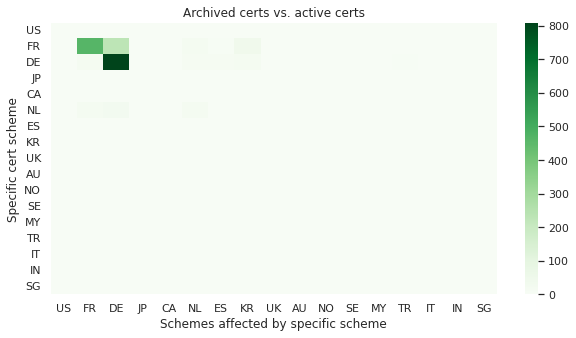

In [79]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 20})
heatmap_result = []


for scheme, counter in scheme_references.items():
    scheme_list = []
    for scheme_key in CC_SCHEMES:
        scheme_list.append(counter.get(scheme_key, 0))
    
    heatmap_result.append(scheme_list)

sns.set(style="whitegrid")
ax = sns.heatmap(heatmap_result, xticklabels=CC_SCHEMES, yticklabels=CC_SCHEMES,cmap="Greens").set_title("Archived certs vs. active certs")
plt.ylabel("Specific cert scheme")
plt.xlabel("Schemes affected by specific scheme")

#### Dependencies among scheme


In [80]:
def return_unique_years_in_dataset():    
    unique_years = set()

    for timestamp_record in scheme_df["not_valid_before"]:
        unique_years.add(timestamp_record.year)
        
    return unique_years

In [81]:
CC_SCHEMES = df["scheme"].unique().tolist()

def discover_scheme_dependiencies_in_dataset(dataset):
    result = {}

    for scheme in CC_SCHEMES:
        counter = collections.Counter()
        scheme_affecting_series = dataset[dataset["scheme"] == scheme]["directly_referencing"]

        for affecting_set in scheme_affecting_series:
            tmp_dict = {}

            for cert_id in affecting_set:
                
                current_scheme = get_scheme_from_cert_id(cert_id)
                tmp_dict[current_scheme] = tmp_dict.get(current_scheme, 0) + 1

            counter.update(tmp_dict)

        result[scheme] = counter

    return result

discover_scheme_dependiencies_in_dataset(scheme_df)

{'KR': Counter(),
 'AU': Counter(),
 'SE': Counter(),
 'NL': Counter({None: 94, 'FR': 19, 'NL': 19, 'DE': 28, 'KR': 1}),
 'CA': Counter({None: 22, 'US': 1}),
 'ES': Counter(),
 'IN': Counter(),
 'MY': Counter(),
 'JP': Counter(),
 'DE': Counter({None: 134,
          'DE': 809,
          'FR': 19,
          'NL': 13,
          'KR': 20,
          'US': 2,
          'ES': 13,
          'TR': 7}),
 'SG': Counter(),
 'US': Counter({'US': 2, None: 3}),
 'IT': Counter(),
 'TR': Counter(),
 'NO': Counter(),
 'FR': Counter({None: 196, 'DE': 229, 'FR': 463, 'KR': 43, 'ES': 7, 'NL': 21}),
 'UK': Counter()}

In [60]:
def get_category_from_cert_id(cert_id):
    category_list = df[df["cert_id"] == cert_id]["category"].tolist()
    
    if not category_list:
        return None
    
    return df[df["cert_id"] == cert_id]["category"].tolist()[0]

CC_CATEGORIES = df["category"].unique()

category_references = {}
category_df = df.copy()

for category in CC_CATEGORIES:
    counter = collections.Counter()
    category_affecting_series = category_df[category_df["category"] == category]["directly_referencing"]
    
    if category_affecting_series is np.nan:
        continue
    
    for affecting_set in category_affecting_series:
        
        if affecting_set is np.nan:
            continue

        tmp_dict = {}
        
        for cert_id in affecting_set:
            current_category = get_category_from_cert_id(cert_id)
            tmp_dict[current_category] = tmp_dict.get(current_category, 0) + 1
        
        counter.update(tmp_dict)
    
    category_references[category] = counter

category_references

{'Access Control Devices and Systems': Counter({'Access Control Devices and Systems': 2}),
 'Boundary Protection Devices and Systems': Counter({None: 11,
          'Boundary Protection Devices and Systems': 10}),
 'Data Protection': Counter({None: 1}),
 'Databases': Counter({'Databases': 8, 'Operating Systems': 2}),
 'Detection Devices and Systems': Counter({'ICs, Smart Cards and Smart Card-Related Devices and Systems': 1}),
 'ICs, Smart Cards and Smart Card-Related Devices and Systems': Counter({'ICs, Smart Cards and Smart Card-Related Devices and Systems': 1361,
          None: 376,
          'Products for Digital Signatures': 9,
          'Other Devices and Systems': 4,
          'Trusted Computing': 8,
          'Detection Devices and Systems': 3,
          'Databases': 1}),
 'Key Management Systems': Counter({None: 2,
          'Other Devices and Systems': 2,
          'Key Management Systems': 5}),
 'Mobility': Counter(),
 'Multi-Function Devices': Counter(),
 'Network and Networ

In [62]:
total = 0
category_self_reference = 0

for category in category_references:
    print(f"Starting category: {category}")
    for referenced_category in category_references[category]:
        if referenced_category is None:
            continue
            
        if category == referenced_category:
            print(f"SAME: {category} {referenced_category}")
            category_self_reference += category_references[category][referenced_category]
        print(f"Other: {category} {referenced_category}")
        total += category_references[category][referenced_category]
    print()

print(total)
print(category_self_reference)

Starting category: Access Control Devices and Systems
SAME: Access Control Devices and Systems Access Control Devices and Systems
Other: Access Control Devices and Systems Access Control Devices and Systems

Starting category: Boundary Protection Devices and Systems
SAME: Boundary Protection Devices and Systems Boundary Protection Devices and Systems
Other: Boundary Protection Devices and Systems Boundary Protection Devices and Systems

Starting category: Data Protection

Starting category: Databases
SAME: Databases Databases
Other: Databases Databases
Other: Databases Operating Systems

Starting category: Detection Devices and Systems
Other: Detection Devices and Systems ICs, Smart Cards and Smart Card-Related Devices and Systems

Starting category: ICs, Smart Cards and Smart Card-Related Devices and Systems
SAME: ICs, Smart Cards and Smart Card-Related Devices and Systems ICs, Smart Cards and Smart Card-Related Devices and Systems
Other: ICs, Smart Cards and Smart Card-Related Device

### Dependencies Among Categories Graph

In [83]:
plot_graphviz_graph(title="References Among Categories", 
                    filename="categories_references", 
                    nodes=CC_CATEGORIES, 
                    data_dict=category_references)

categories_references has been rendered successfully


In [84]:
make_stacked_bar_plot(category_references, 
                      title="References Among Categories", 
                      xaxis_label="Categories", 
                      yaxis_label="Count")

In [85]:
make_heatmap_plot(category_references,
                  title="References Among Categories",
                  xaxis_label="Referenced Category",
                  yaxis_label="Referencing Category")

### Dependencies among manufacturers

In [86]:
def get_manufacturer_from_cert_id(cert_id):
    category_list = df[df["cert_id"] == cert_id]["manufacturer"].tolist()
    
    if not category_list:
        return None
    
    return df[df["cert_id"] == cert_id]["manufacturer"].tolist()[0]


CC_MANUFACTURERS = df[df["manufacturer"].notna()]["manufacturer"].unique().tolist()


manufacturers_references = {}
manufacturer_df = df.copy()

for manufacturer in CC_MANUFACTURERS:
    counter = collections.Counter()
    manufacturer_affecting_series = manufacturer_df[manufacturer_df["manufacturer"] == manufacturer]["directly_referencing"]
    
    if manufacturer_affecting_series is np.nan:
        continue
    
    for affecting_set in manufacturer_affecting_series:
        
        if affecting_set is np.nan:
            continue

        tmp_dict = {}
        
        for cert_id in affecting_set:
            current_manufacturer = get_manufacturer_from_cert_id(cert_id)
            tmp_dict[current_manufacturer] = tmp_dict.get(current_manufacturer, 0) + 1
        
        counter.update(tmp_dict)
    
    manufacturers_references[manufacturer] = counter


In [87]:
manufacturers_references["Infineon Technologies AG"]
count = 0 

for manufacturer in manufacturers_references:
    if "Infineon Technologies AG" in manufacturers_references[manufacturer]:
        count += 1
        
print(count)

36


In [88]:
plot_graphviz_graph(title="Dependencies Among Manufacturers", 
                    filename="manufacturers_references", 
                    nodes=CC_MANUFACTURERS, 
                    data_dict=manufacturers_references)

manufacturers_references has been rendered successfully


### Dependencies among laboratories


In [ ]:
def extract_cert_lab(lab_list):
    if lab_list is np.nan:
        return None
    return lab_list[0]


df["extracted_lab"] = df["cert_lab"].apply(extract_cert_lab)
lab_df = df[df["extracted_lab"].notna()]
lab_df["extracted_lab"].head()

def get_laboratory_from_cert_id(cert_id):
    lab = df[df["cert_id"] == cert_id]["extracted_lab"].tolist()
    
    if not lab:
        return None
    
    return lab[0]



CC_LABS = df[df["extracted_lab"].notna()]["extracted_lab"].unique().tolist()

lab_references = {}

for lab in CC_LABS:
    counter = collections.Counter()
    lab_affecting_series = lab_df[lab_df["extracted_lab"] == lab]["directly_referencing"]
    
    if lab_affecting_series is np.nan:
        continue
    
    for affecting_set in lab_affecting_series:
        
        if affecting_set is np.nan:
            continue

        tmp_dict = {}
        
        for cert_id in affecting_set:
            current_lab = get_laboratory_from_cert_id(cert_id)
            tmp_dict[current_lab] = tmp_dict.get(current_lab, 0) + 1
        
        counter.update(tmp_dict)
    
    lab_references[lab] = counter

lab_references

### Graph Of References Among Laboratories

In [ ]:
plot_graphviz_graph(title="Dependencies Among Laboratories", 
                    filename="lab_references", 
                    nodes=CC_LABS, 
                    data_dict=lab_references)

In [ ]:
lab_references_df = pd.DataFrame(lab_references).transpose()
lab_references_df.drop([None], axis=1, inplace=True)  # dropping None column
fig = px.bar(lab_references_df, title="Dependencies Among Laboratories")
fig.show()

### References Among Archived Certs

In [ ]:
def get_status_from_cert_id(cert_id):
    status_list = df[df["cert_id"] == cert_id]["status"].tolist()
    
    if not status_list:
        return None
    
    return status_list[0]

In [ ]:
archived_certs_df = df[(df["status"] == "archived") & (df["cert_id"].notna())]
archived_cert_ids = set()

# Create nodes for archived certificates
for cert_id in archived_certs_df["cert_id"]:
    archived_cert_ids.add(cert_id)

# Building dependencies
archived_certs_references = {}
directly_affecting_archived_certs = archived_certs_df[archived_certs_df["directly_referencing"].notna()]["cert_id"]

for cert_id in directly_affecting_archived_certs:
    counter = collections.Counter()
    archived_cert_id_affecting_series = archived_certs_df[archived_certs_df["cert_id"] == cert_id]["directly_referencing"]
    
    for affecting_set in archived_cert_id_affecting_series:
        
        if affecting_set is np.nan:
            continue

        tmp_dict = {}
        
        for affected_cert_id in affecting_set:
            cert_id_status = get_status_from_cert_id(affected_cert_id)
            
            if cert_id_status != "archived":
                continue
            
            tmp_dict[affected_cert_id] = 1
        
        counter.update(tmp_dict)
    
    archived_certs_references[cert_id] = counter

In [ ]:
plot_graphviz_graph(title="Dependencies Among Archived Certificates", 
                    filename="archived_certs_references", 
                    nodes=archived_cert_ids, 
                    data_dict=archived_certs_references)

### References Among Active Certs


In [ ]:
active_certs_df = df[(df["status"] == "active") & (df["cert_id"].notna())]
active_cert_ids = set()

# Create nodes for archived certificates
for cert_id in active_certs_df["cert_id"]:
    active_cert_ids.add(cert_id)
    
# Filter all affecting active cert ids
directly_affecting_active_certs = active_certs_df[active_certs_df["directly_referencing"].notna()]["cert_id"]

active_certs_references = {}

for cert_id in directly_affecting_active_certs:
    counter = collections.Counter()
    active_cert_id_affecting_series = active_certs_df[active_certs_df["cert_id"] == cert_id]["directly_referencing"]
    
    for affecting_set in active_cert_id_affecting_series:            
        if affecting_set is np.nan:
            continue

        tmp_dict = {}
        
        for affected_cert_id in affecting_set:
            cert_id_status = get_status_from_cert_id(affected_cert_id)
            
            if cert_id_status != "active":
                continue
            
            tmp_dict[affected_cert_id] = 1
        
        counter.update(tmp_dict)
    
    active_certs_references[cert_id] = counter

In [ ]:
plot_graphviz_graph(title="Dependencies Among Active Certificates", 
                    filename="active_certs_references", 
                    nodes=active_cert_ids, 
                    data_dict=active_certs_references)

### References Among Active Referencing Archived Certs

In [ ]:
# Stage 2 - pridat barvy k certu, jestli jsou active nebo archived proste
all_cert_ids = set()

for cert_id in df[df["cert_id"].notna()]["cert_id"]:
    all_cert_ids.add(cert_id)

active_to_archived_certs_references = {}

for cert_id in directly_affecting_active_certs:
    counter = collections.Counter()
    active_cert_id_affecting_series = active_certs_df[active_certs_df["cert_id"] == cert_id]["directly_referencing"]
    
    for affecting_set in active_cert_id_affecting_series:            
        if affecting_set is np.nan:
            continue

        tmp_dict = {}
        
        for affected_cert_id in affecting_set:
            cert_id_status = get_status_from_cert_id(affected_cert_id)
            
            if cert_id_status != "archived":
                continue
            
            tmp_dict[affected_cert_id] = 1
        
        counter.update(tmp_dict)
    
    active_to_archived_certs_references[cert_id] = counter

In [ ]:
plot_graphviz_graph(title="Active Certs Directly Affecting Archived Certs", 
                    filename="active_to_archived_certs_references", 
                    nodes=all_cert_ids, 
                    data_dict=active_to_archived_certs_references)

### Playing with plotly


#### Certs which became active in specified year - grouped by categories

In [ ]:
dropdown_years = sorted(df["not_valid_before"].dt.year.unique())
dropdown_years = dropdown_years[::-1]  # descending order of the years
categories = df["category"].unique()
visibility_bools = [False for _ in dropdown_years]
dropdown_buttons = []
graphs = []


for year in dropdown_years:
    data = df[df["not_valid_before"].dt.year == year]
    category_occurences = []
    
    for category in categories:
        category_occurences.append((data["category"] == category).sum())
    
    graph = go.Bar(
        name=str(year),
        x=categories,
        y=category_occurences,
    )
    
    graphs.append(graph)


fig = go.Figure(data=graphs)


for index, year in enumerate(dropdown_years):
    year_bool_list = visibility_bools[:]
    year_bool_list[index] = True
    
    item = dict(
        label=str(year),
        method="update",
        args=[{"visible": year_bool_list,
               "title": str(year)}]
    )
    
    dropdown_buttons.append(item)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons
        )
    ])
  
fig.show()

#### Certs which became archived in specified year - grouped by categories

In [ ]:
dropdown_years = sorted(df["not_valid_before"].dt.year.unique())
dropdown_years = dropdown_years[::-1]  # descending order of the years
categories = df["category"].unique()
visibility_bools = [False for _ in dropdown_years]
dropdown_buttons = []
graphs = []


for year in dropdown_years:
    data = df[df["not_valid_after"].dt.year == year]
    category_occurences = []
    
    for category in categories:
        category_occurences.append((data["category"] == category).sum())
    
    graph = go.Bar(
        name=str(year),
        x=categories,
        y=category_occurences,
    )
    
    graphs.append(graph)


fig = go.Figure(data=graphs)


for index, year in enumerate(dropdown_years):
    year_bool_list = visibility_bools[:]
    year_bool_list[index] = True
    
    item = dict(
        label=str(year),
        method="update",
        args=[{"visible": year_bool_list,
               "title": str(year)}]
    )
    
    dropdown_buttons.append(item)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons
        )
    ])
  
fig.show()

### Vulnerabilities dependency

In [ ]:
direct_cves_df = df[df["direct_dependency_cves"].notna()].copy()
indirect_cves_df = df[df["indirect_dependency_cves"].notna()].copy()

#### Most common CVE in direct_dependency_cves

In [ ]:
direct_cves_dict = {}
max_set = None
max_number = None


for cve_set in direct_cves_df["direct_dependency_cves"]:
    
    if max_set is None or len(cve_set) > max_number:
        max_set = cve_set
        max_number = len(cve_set)
    
    for cve_str in cve_set:
        direct_cves_dict[cve_str] = direct_cves_dict.get(cve_str, 0) + 1
        
        
max_count = 0
max_key = None


for key, count in direct_cves_dict.items():
    if count > max_count:
        max_count = count
        max_key = key
        
print(max_key)
print(max_count)

#direct_cves_dict

#direct_cves_df[direct_cves_df["direct_dependency_cves"] == max_set]

In [ ]:
df[(df["related_cves"].notna()) & (df["directly_referencing"].notna())].shape[0]


#### Record with the most assigned CVEs

In [ ]:
max_cves_cert_id = None
max_cves_length = None 


for _, row in df[df["related_cves"].notna()].iterrows():
    if max_cves_cert_id is None or max_cves_length < len(row["related_cves"]):
        max_cves_cert_id = row["cert_id"]
        max_cves_length = len(row["related_cves"])

df[df["cert_id"] == max_cves_cert_id]["related_cves"]

#### Record with the most assigned direct_dependency_cves

In [ ]:
max_cves_cert_id = None
max_cves_length = None 

for _, row in direct_cves_df.iterrows():
    if max_cves_cert_id is None or max_cves_length < len(row["direct_dependency_cves"]):
        max_cves_cert_id = row["cert_id"]
        max_cves_length = len(row["direct_dependency_cves"])

df[df["cert_id"] == max_cves_cert_id]["name"]

In [ ]:
max_cves_cert_id = None
max_cves_length = None 


for _, row in direct_cves_df.iterrows():
    if max_cves_cert_id is None or max_cves_length < len(row["indirect_dependency_cves"]):
        max_cves_cert_id = row["cert_id"]
        max_cves_length = len(row["indirect_dependency_cves"])

df[df["cert_id"] == max_cves_cert_id]["directly_referenced_by"]

In [ ]:
df[df['cert_id'] == "BSI-DSZ-CC-0577-2009"]["name"].tolist()[0]

In [ ]:
# Is there any Roca vulnerability in the dataset
# Is there any Minerva vulnerability in the dataset

MINERVA_CVES = ["CVE-2019-15809", "CVE-2019-13627", "CVE-2019-13628", "CVE-2019-13629", "CVE-2019-2894", "CVE-2019-14318"]
count = 0
for _, row in df[df["related_cves"].notna()].iterrows():
    count += 1 
    for cve in row["related_cves"]:
        print(cve)
        if cve in MINERVA_CVES:
            print("found")

print("Done")
print(count)

In [ ]:
df[df["related_cves"].notna()]